# HR Overtime Prediction and Forecasting
## Predicción y Pronóstico de Horas Extra de RRHH

Los componentes principales incluyen:

* Carga de datos históricos desde SQL Server con manejo de datos faltantes mediante interpolación.
* Análisis exploratorio con gráficas ACF/PACF y detección automática del período estacional.
* Preprocesamiento para garantizar estacionariedad (transformaciones logarítmicas o diferenciación) y detección de outliers con filtrado de Hampel.
* Entrenamiento de modelos SARIMA con selección automática de parámetros, validación cruzada para series temporales, y diagnóstico de residuos.
* Generación de predicciones con intervalos de confianza.
* Visualización interactiva con Plotly para datos históricos y pronósticos.
* Almacenamiento de modelos, predicciones, y métricas en SQL Server.

Objetivo: Producir pronósticos precisos y robustos de horas extra por departamento, minimizando la intervención manual y asegurando la calidad del modelo.

## 1. Importar Librerías y Configuración

Importamos las librerías necesarias para análisis, modelado, visualización, y conexión con la base de datos. Configuramos logging para trazabilidad y suprimimos advertencias innecesarias.

In [58]:
import pandas as pd
import numpy as np
import pymssql
import logging
import datetime
from datetime import timedelta, datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import median_abs_deviation
from scipy.signal import correlate
import joblib
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Configurar advertencias y logging
warnings.filterwarnings("ignore")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('overtime_forecast.log')
    ]
)

## 2. Conectar a la Base de Datos
Establecemos una conexión segura a SQL Server para cargar datos históricos y almacenar resultados.

In [59]:
def get_db_connection():

    SQL_SERVER = "172.28.192.1:50121"
    SQL_DB = "HR_Analytics"
    SQL_USER = "sa"
    SQL_PASSWORD = "123456"
    try:
        conn = pymssql.connect(
            server=SQL_SERVER,
            database=SQL_DB,
            user=SQL_USER,
            password=SQL_PASSWORD
        )
        logging.info("Conexión a la base de datos exitosa")
        return conn
    except Exception as e:
        logging.error(f"Error de conexión a la base de datos: {e}")
        raise

## 3. Cargar y Procesar Datos Históricos

Cargamos los datos históricos, manejamos datos faltantes con interpolación, aplicamos preprocesamiento para estacionariedad, y detectamos outliers con el filtrado de Hampel.

2025-05-24 22:17:13,276 - INFO - Conexión a la base de datos exitosa
2025-05-24 22:17:18,001 - INFO - Datos cargados: 438 registros
2025-05-24 22:17:18,028 - WARNING - Outliers detectados en Finance:
     work_date department  total_overtime
288 2024-12-01    Finance          219.91
300 2024-12-15    Finance          224.39
2025-05-24 22:17:18,059 - WARNING - Outliers detectados en HR:
     work_date department  total_overtime
301 2024-12-15         HR          257.14
355 2025-02-16         HR          132.46
2025-05-24 22:17:18,110 - WARNING - Outliers detectados en Inventory:
     work_date department  total_overtime
14  2024-01-14  Inventory          174.03
134 2024-06-02  Inventory          344.03
272 2024-11-10  Inventory          197.40
290 2024-12-01  Inventory          417.73
296 2024-12-08  Inventory          420.43
302 2024-12-15  Inventory          427.05
332 2025-01-19  Inventory          165.09
2025-05-24 22:17:18,130 - WARNING - Outliers detectados en IT:
     work_date d

Valores nulos:
 work_date         0
department        0
total_overtime    0
dtype: int64
Duplicados: 0


2025-05-24 22:17:18,219 - WARNING - Outliers detectados en Sales:
     work_date department  total_overtime
137 2024-06-02      Sales          362.88
143 2024-06-09      Sales          442.26
155 2024-06-23      Sales          354.37
293 2024-12-01      Sales          525.83
299 2024-12-08      Sales          472.26
305 2024-12-15      Sales          471.93
311 2024-12-22      Sales          397.47
317 2024-12-29      Sales          355.57
2025-05-24 22:17:18,289 - INFO - Analizando departamento: Finance
2025-05-24 22:17:18,311 - INFO - Estadísticas para Finance:
count                            73.000000
mean                            148.861644
std                              23.179031
min                              99.220000
25%                             132.480000
50%                             149.380000
75%                             161.900000
max                             201.120000
missing_count                     0.000000
missing_percentage                0.000000


Resumen de datos:
Departamentos únicos: ['Finance' 'HR' 'Inventory' 'IT' 'Marketing' 'Sales']
Fechas únicas: [Timestamp('2023-12-31 00:00:00'), Timestamp('2024-01-07 00:00:00'), Timestamp('2024-01-14 00:00:00'), Timestamp('2024-01-21 00:00:00'), Timestamp('2024-01-28 00:00:00'), Timestamp('2024-02-04 00:00:00'), Timestamp('2024-02-11 00:00:00'), Timestamp('2024-02-18 00:00:00'), Timestamp('2024-02-25 00:00:00'), Timestamp('2024-03-03 00:00:00'), Timestamp('2024-03-10 00:00:00'), Timestamp('2024-03-17 00:00:00'), Timestamp('2024-03-24 00:00:00'), Timestamp('2024-03-31 00:00:00'), Timestamp('2024-04-07 00:00:00'), Timestamp('2024-04-14 00:00:00'), Timestamp('2024-04-21 00:00:00'), Timestamp('2024-04-28 00:00:00'), Timestamp('2024-05-05 00:00:00'), Timestamp('2024-05-12 00:00:00'), Timestamp('2024-05-19 00:00:00'), Timestamp('2024-05-26 00:00:00'), Timestamp('2024-06-02 00:00:00'), Timestamp('2024-06-09 00:00:00'), Timestamp('2024-06-16 00:00:00'), Timestamp('2024-06-23 00:00:00'), Timest

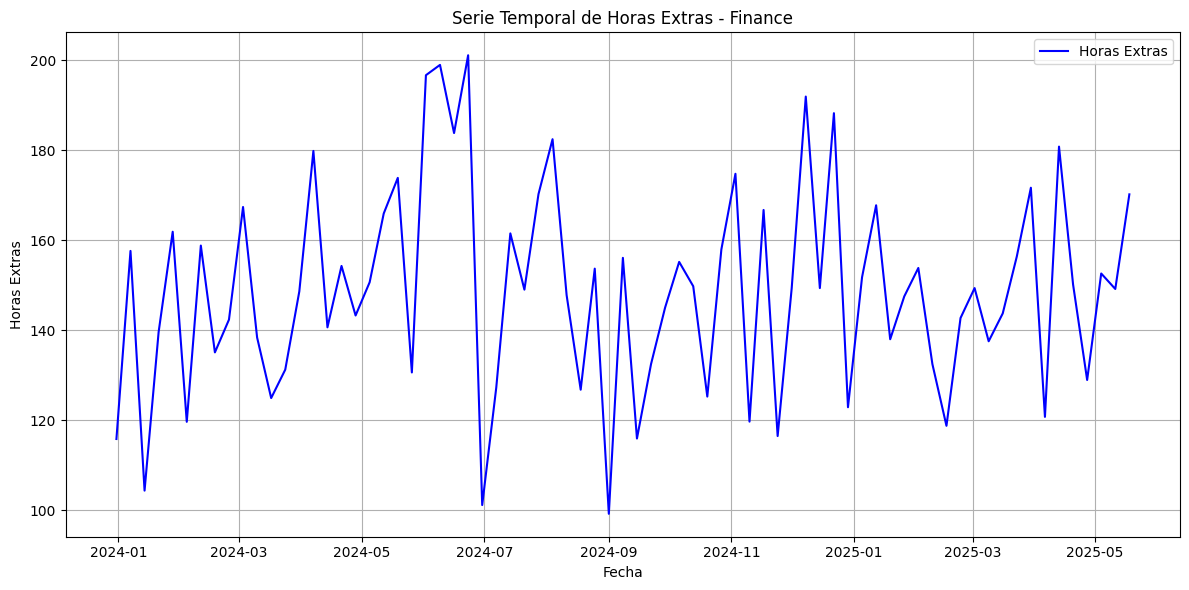

2025-05-24 22:17:20,141 - INFO - Gráfico de serie temporal renderizado para Finance


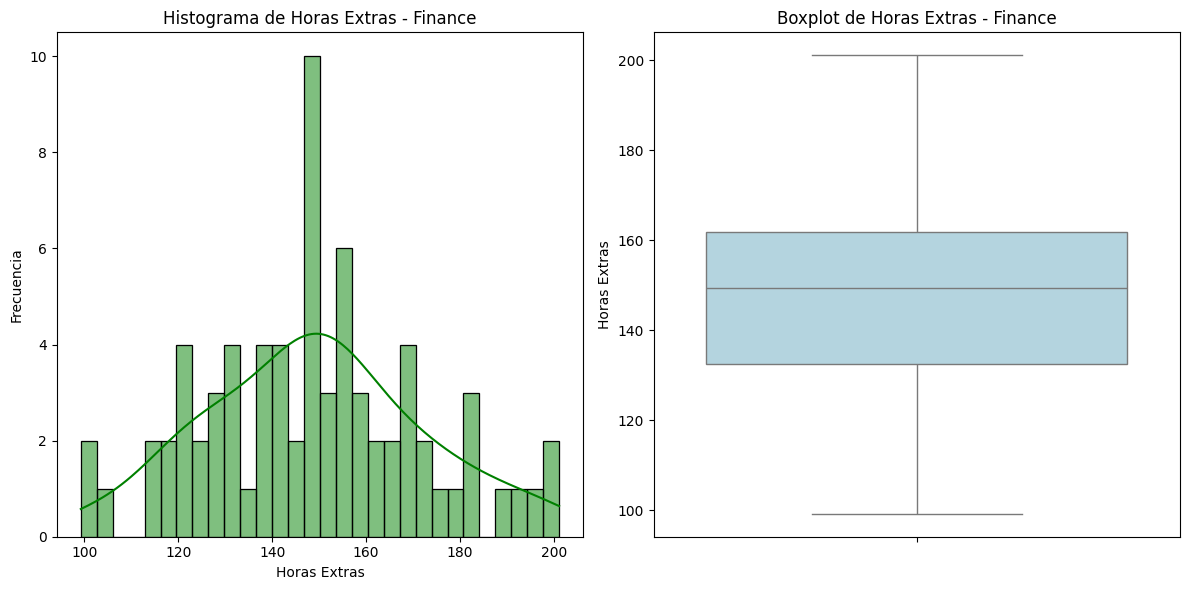

2025-05-24 22:17:22,742 - INFO - Gráficos de distribución renderizados para Finance


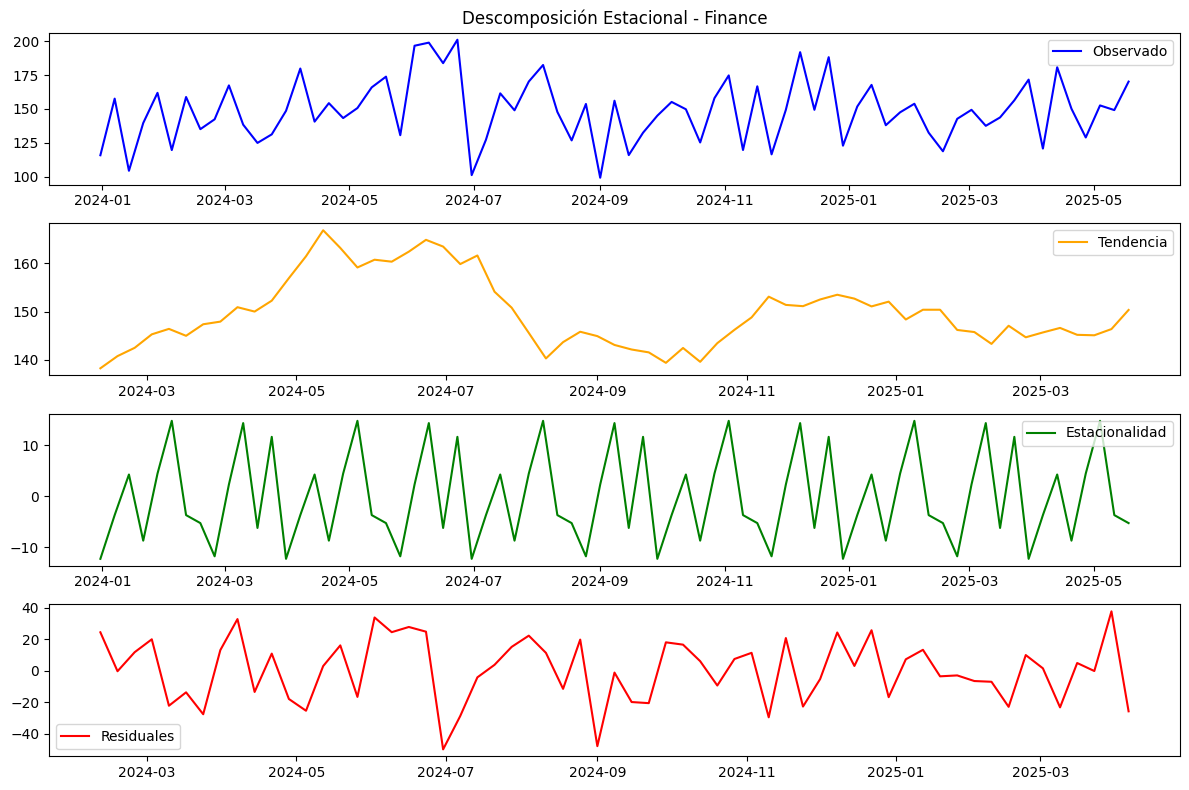

2025-05-24 22:17:27,620 - INFO - Gráfico de descomposición estacional renderizado para Finance
2025-05-24 22:17:27,625 - INFO - Problemas de índice para Finance: {'is_monotonic': True, 'has_duplicates': False, 'missing_dates': 0}
2025-05-24 22:17:27,628 - INFO - Analizando departamento: HR
2025-05-24 22:17:27,655 - INFO - Estadísticas para HR:
count                            73.000000
mean                            195.410822
std                              22.865674
min                             140.610000
25%                             183.020000
50%                             196.640000
75%                             210.730000
max                             245.600000
missing_count                     0.000000
missing_percentage                0.000000
outlier_count_post_treatment      1.000000
Name: total_overtime, dtype: float64


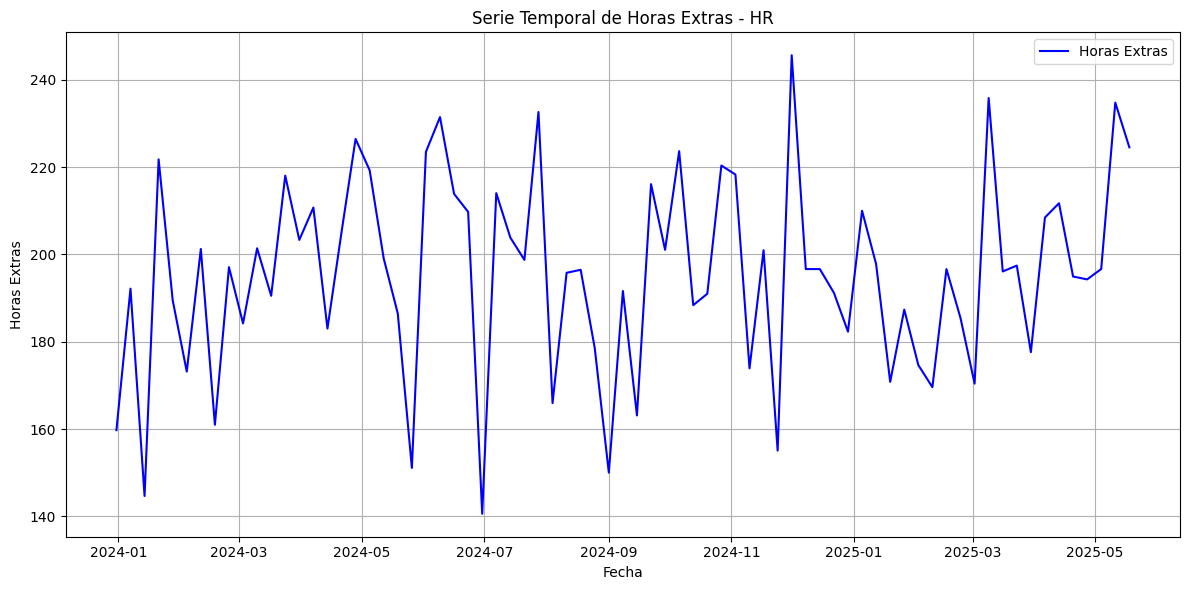

2025-05-24 22:17:29,189 - INFO - Gráfico de serie temporal renderizado para HR


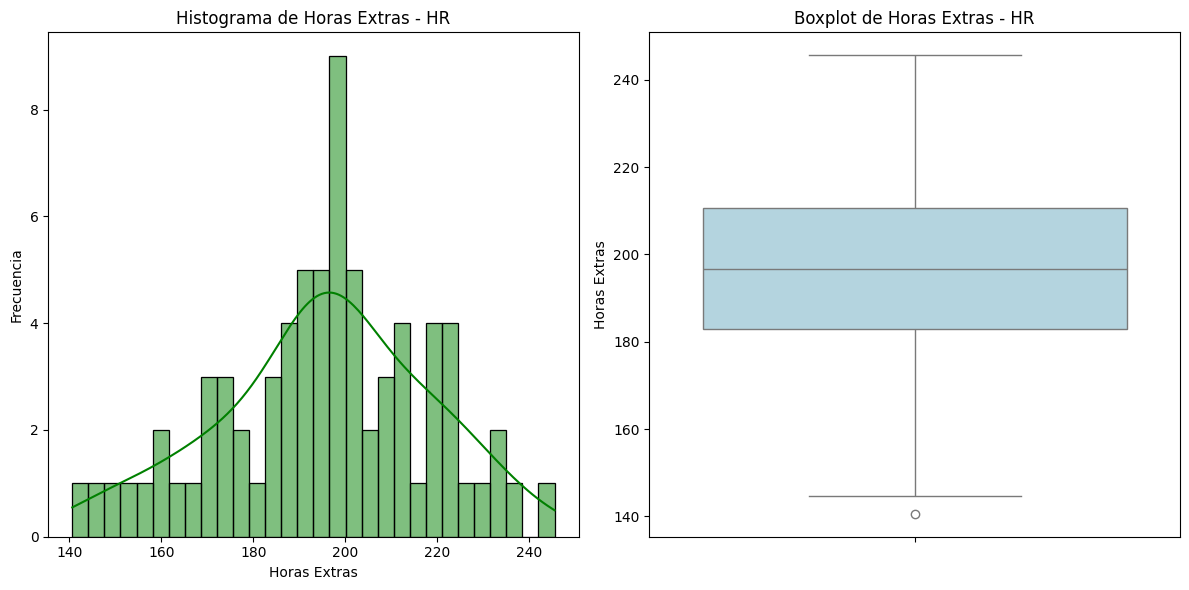

2025-05-24 22:17:32,530 - INFO - Gráficos de distribución renderizados para HR


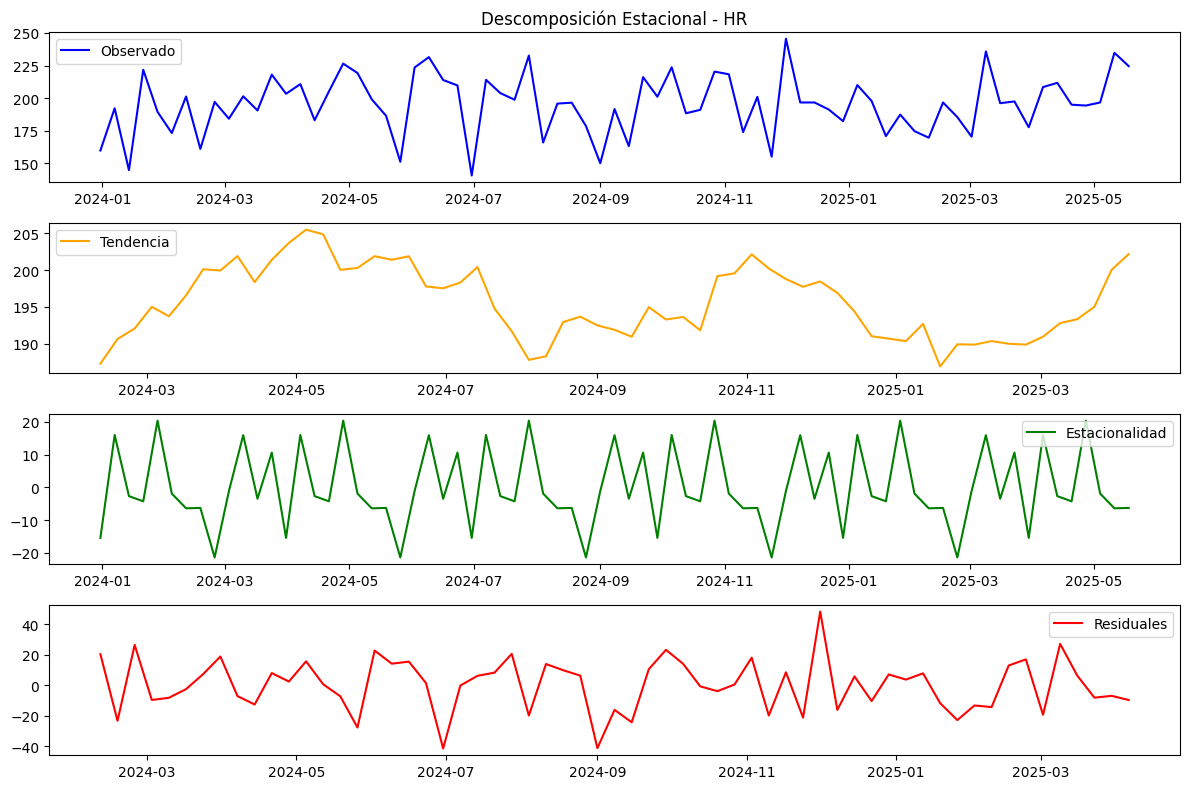

2025-05-24 22:17:36,916 - INFO - Gráfico de descomposición estacional renderizado para HR
2025-05-24 22:17:36,926 - INFO - Problemas de índice para HR: {'is_monotonic': True, 'has_duplicates': False, 'missing_dates': 0}
2025-05-24 22:17:36,928 - INFO - Analizando departamento: Inventory
2025-05-24 22:17:36,947 - INFO - Estadísticas para Inventory:
count                            73.000000
mean                            267.778904
std                              24.906281
min                             201.110000
25%                             256.550000
50%                             267.490000
75%                             282.490000
max                             334.470000
missing_count                     0.000000
missing_percentage                0.000000
outlier_count_post_treatment      4.000000
Name: total_overtime, dtype: float64


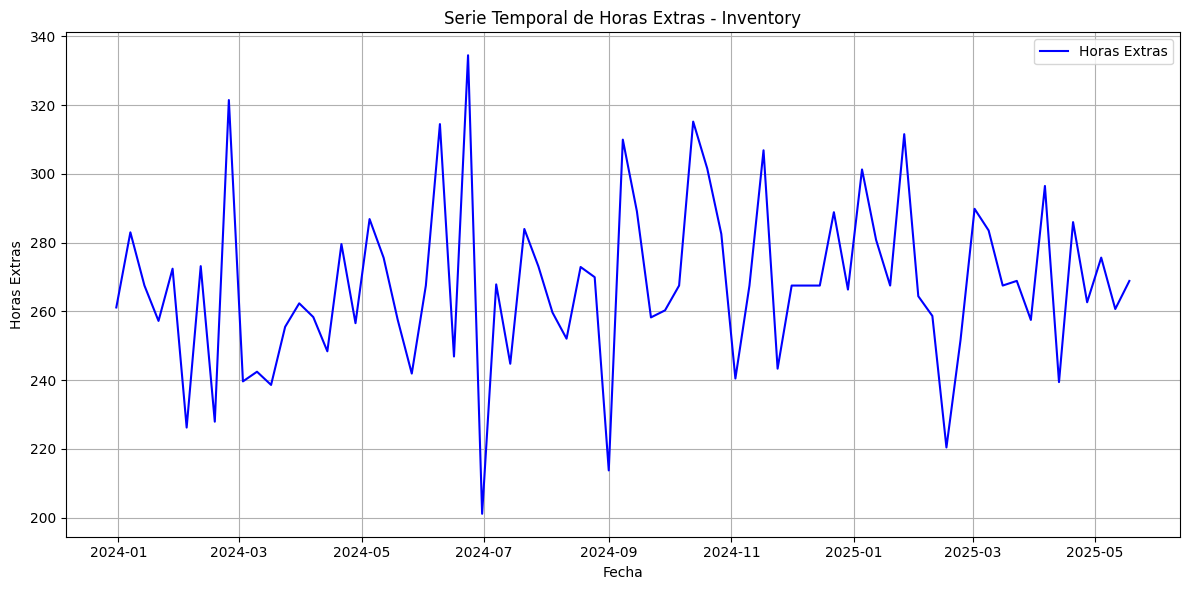

2025-05-24 22:17:39,274 - INFO - Gráfico de serie temporal renderizado para Inventory


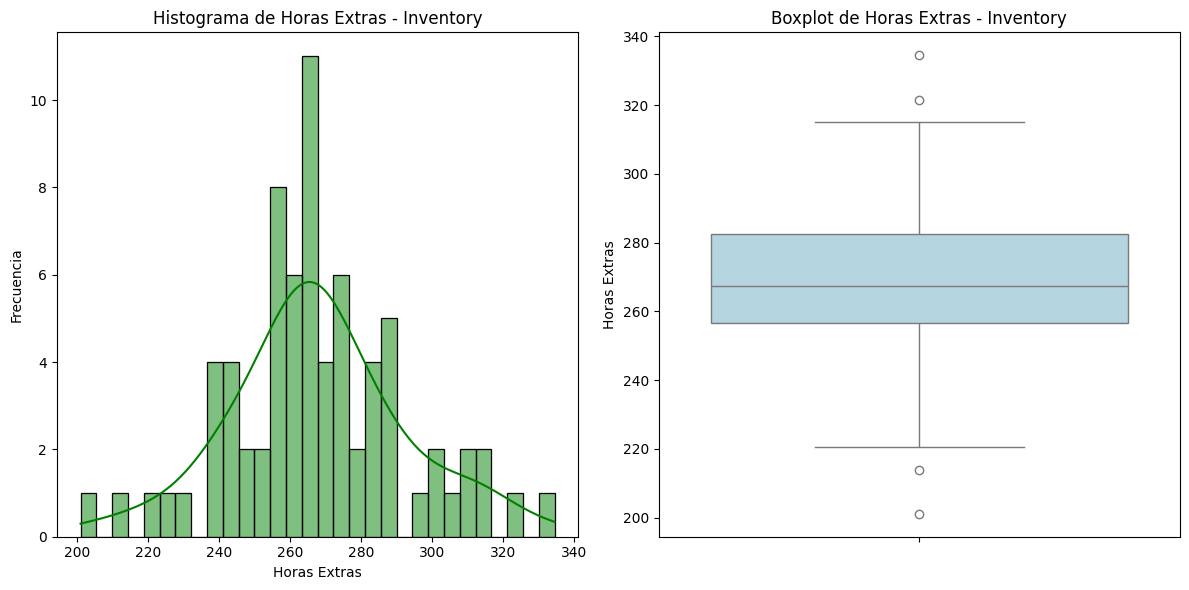

2025-05-24 22:17:42,896 - INFO - Gráficos de distribución renderizados para Inventory


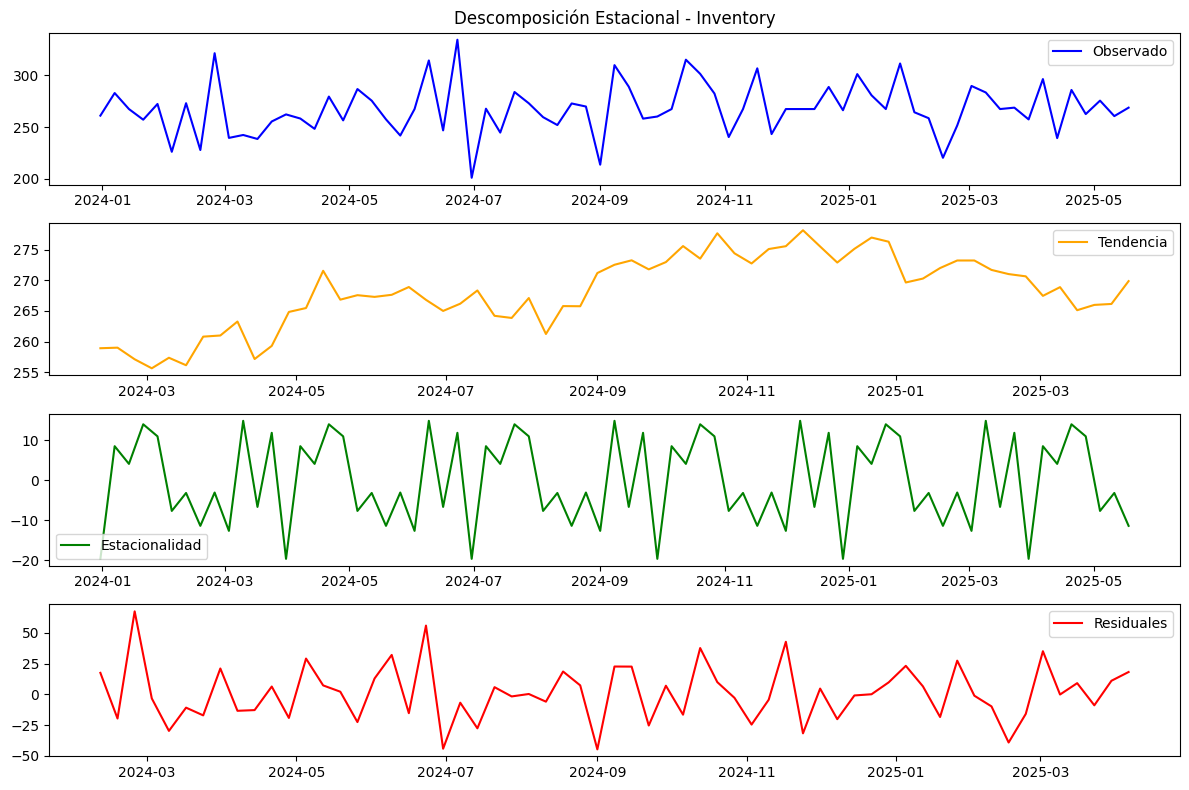

2025-05-24 22:17:47,360 - INFO - Gráfico de descomposición estacional renderizado para Inventory
2025-05-24 22:17:47,365 - INFO - Problemas de índice para Inventory: {'is_monotonic': True, 'has_duplicates': False, 'missing_dates': 0}
2025-05-24 22:17:47,367 - INFO - Analizando departamento: IT
2025-05-24 22:17:47,428 - INFO - Estadísticas para IT:
count                            73.000000
mean                            210.087397
std                              24.418686
min                             155.200000
25%                             194.160000
50%                             211.460000
75%                             223.580000
max                             264.020000
missing_count                     0.000000
missing_percentage                0.000000
outlier_count_post_treatment      0.000000
Name: total_overtime, dtype: float64


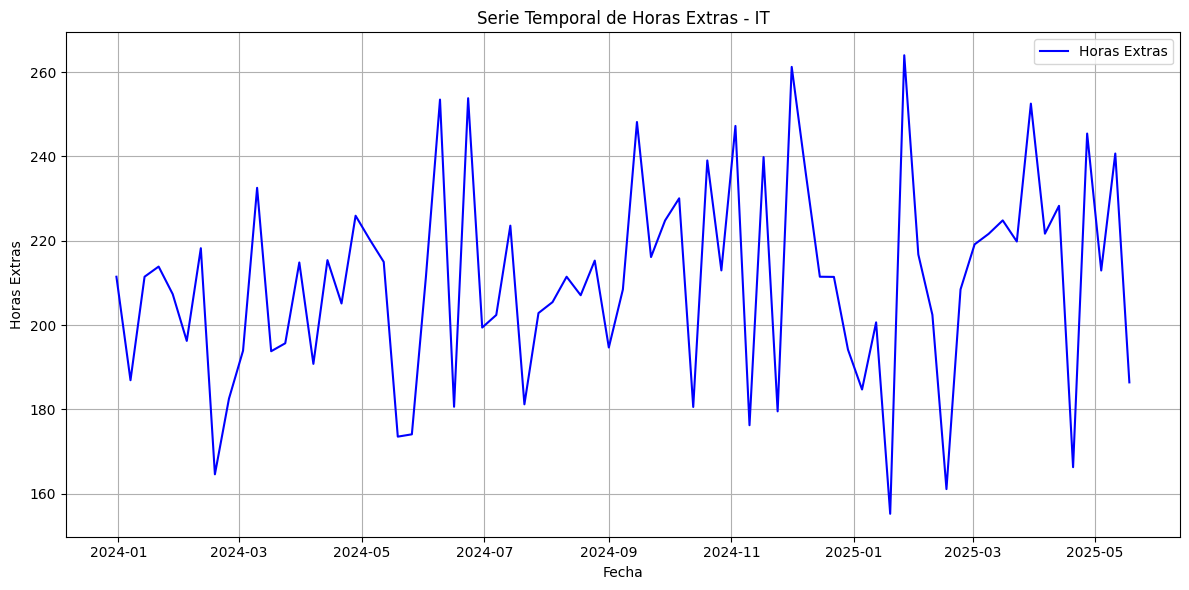

2025-05-24 22:17:50,813 - INFO - Gráfico de serie temporal renderizado para IT


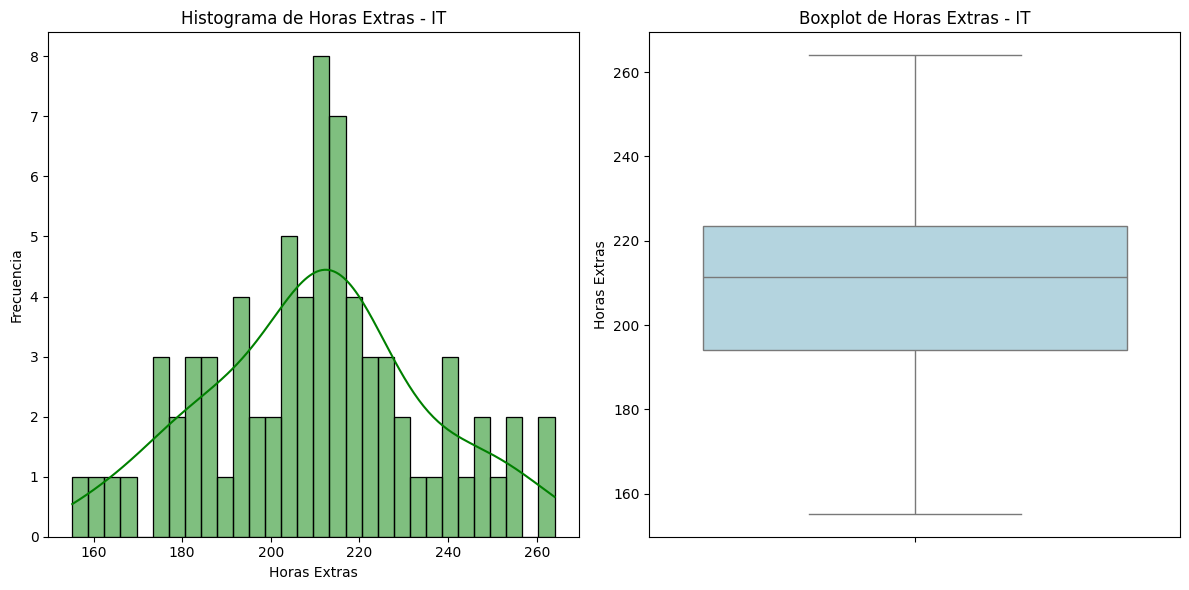

2025-05-24 22:17:52,872 - INFO - Gráficos de distribución renderizados para IT


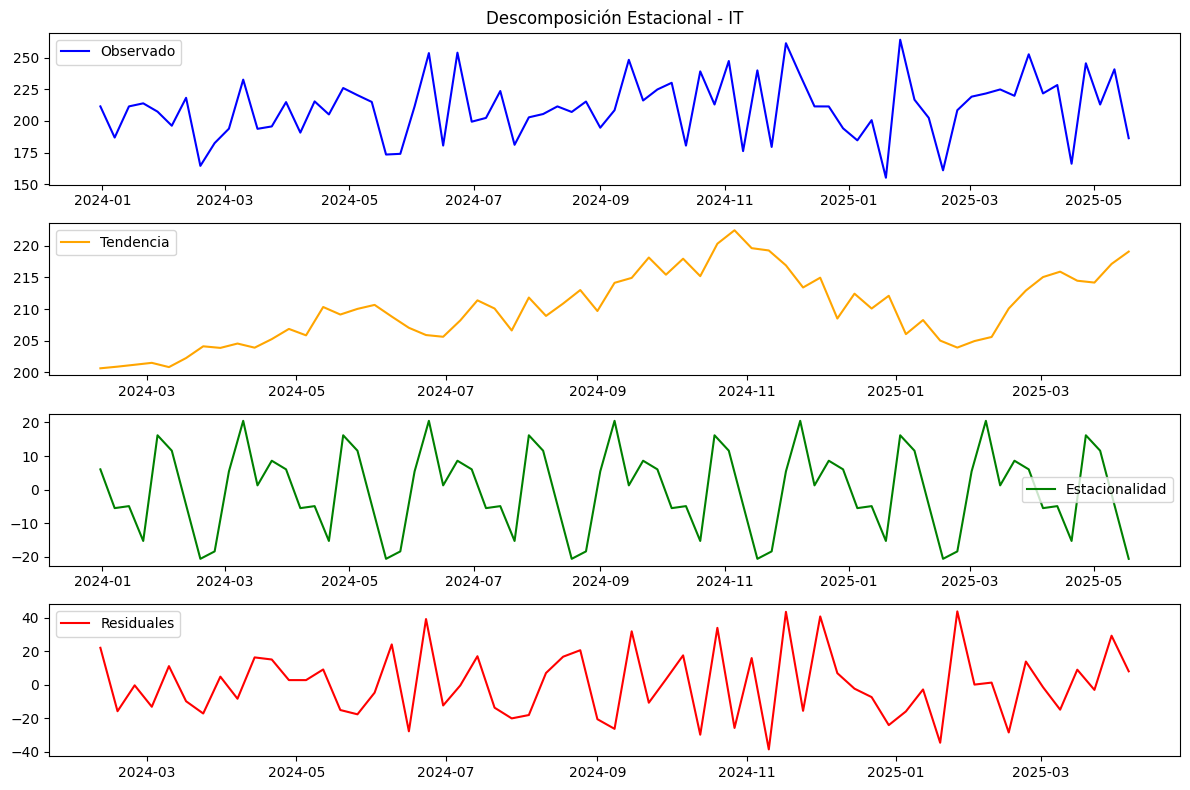

2025-05-24 22:17:57,740 - INFO - Gráfico de descomposición estacional renderizado para IT
2025-05-24 22:17:57,745 - INFO - Problemas de índice para IT: {'is_monotonic': True, 'has_duplicates': False, 'missing_dates': 0}
2025-05-24 22:17:57,748 - INFO - Analizando departamento: Marketing
2025-05-24 22:17:57,850 - INFO - Estadísticas para Marketing:
count                            73.000000
mean                            230.093973
std                              30.660730
min                             154.820000
25%                             208.560000
50%                             232.100000
75%                             248.290000
max                             313.990000
missing_count                     0.000000
missing_percentage                0.000000
outlier_count_post_treatment      1.000000
Name: total_overtime, dtype: float64


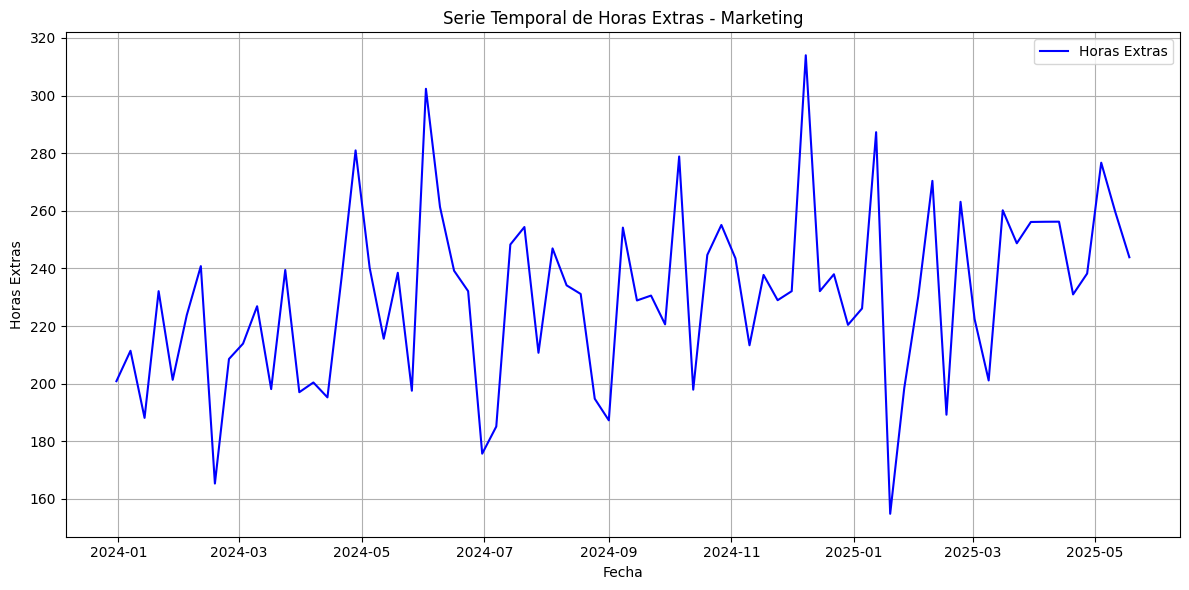

2025-05-24 22:18:00,038 - INFO - Gráfico de serie temporal renderizado para Marketing


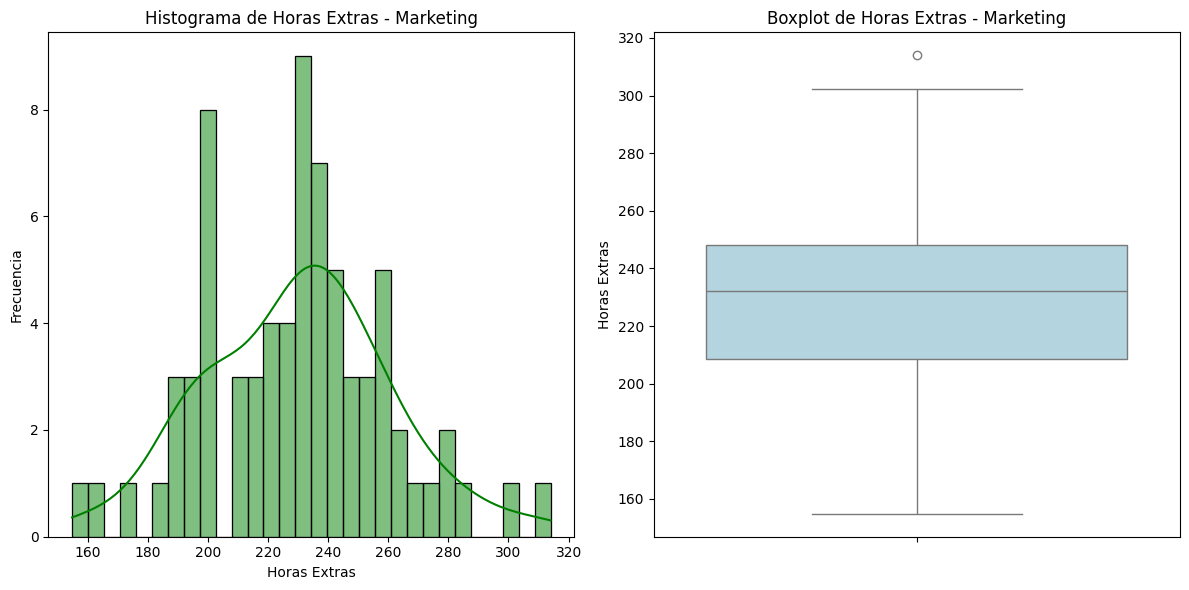

2025-05-24 22:18:02,904 - INFO - Gráficos de distribución renderizados para Marketing


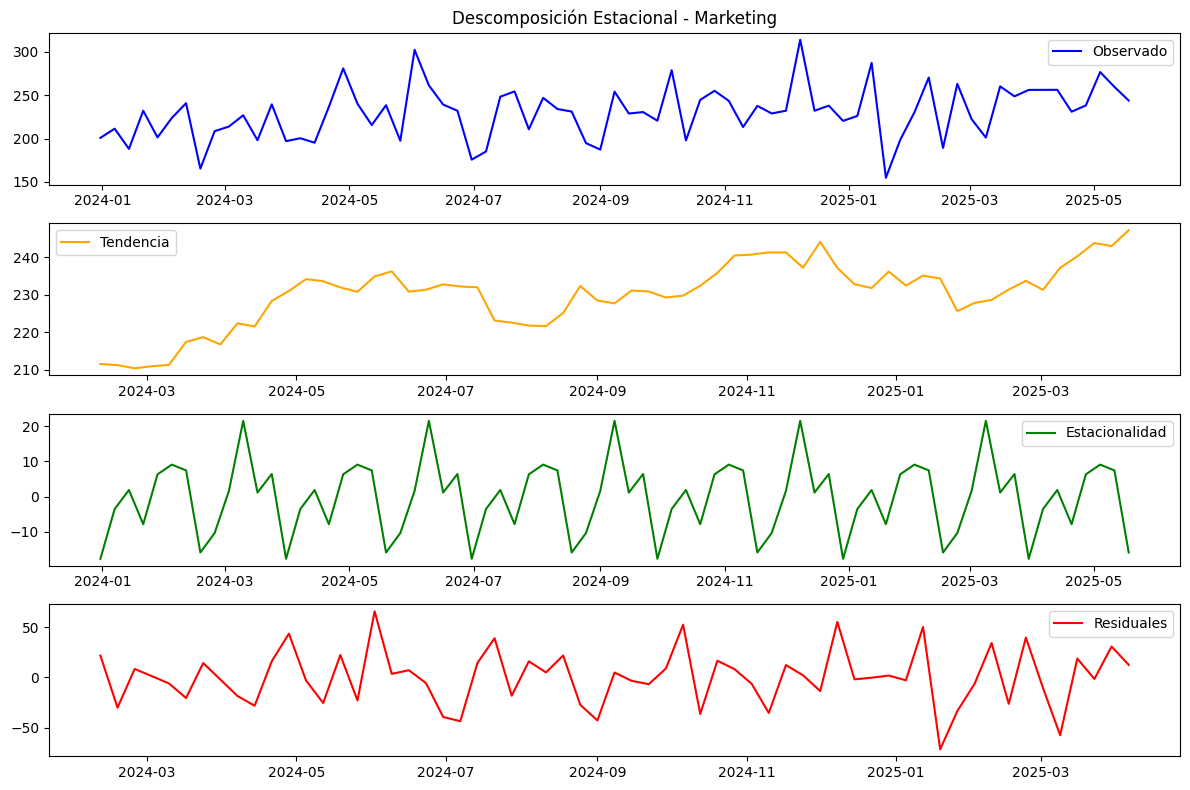

2025-05-24 22:18:07,813 - INFO - Gráfico de descomposición estacional renderizado para Marketing
2025-05-24 22:18:07,819 - INFO - Problemas de índice para Marketing: {'is_monotonic': True, 'has_duplicates': False, 'missing_dates': 0}
2025-05-24 22:18:07,824 - INFO - Analizando departamento: Sales
2025-05-24 22:18:07,845 - INFO - Estadísticas para Sales:
count                            73.000000
mean                            234.787671
std                              28.125463
min                             167.690000
25%                             217.760000
50%                             241.670000
75%                             251.870000
max                             314.420000
missing_count                     0.000000
missing_percentage                0.000000
outlier_count_post_treatment      1.000000
Name: total_overtime, dtype: float64


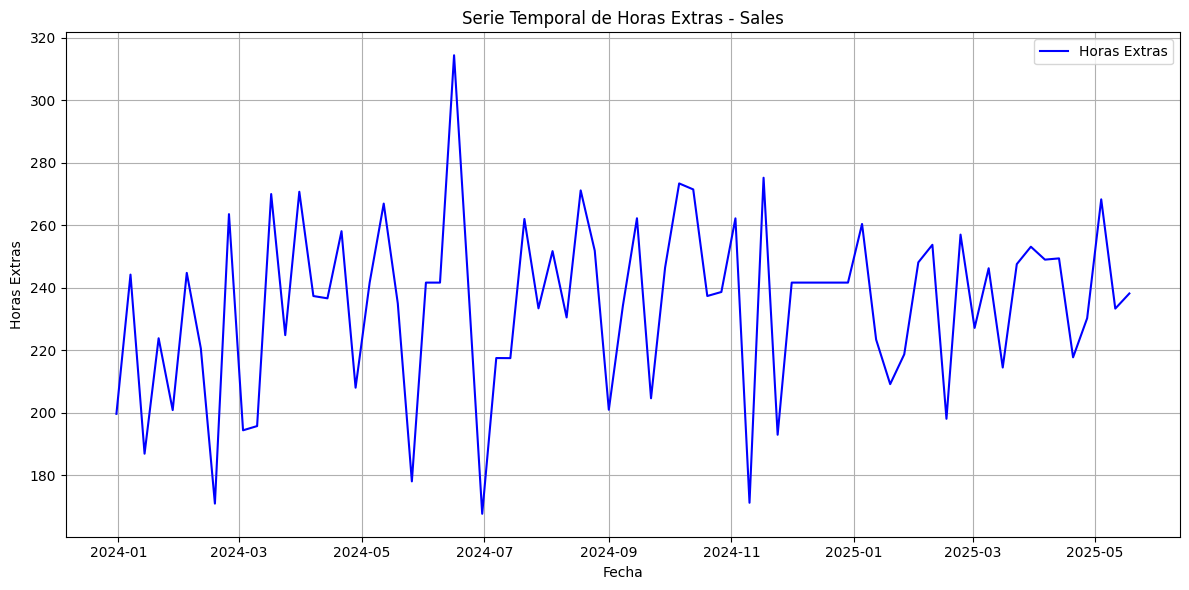

2025-05-24 22:18:10,262 - INFO - Gráfico de serie temporal renderizado para Sales


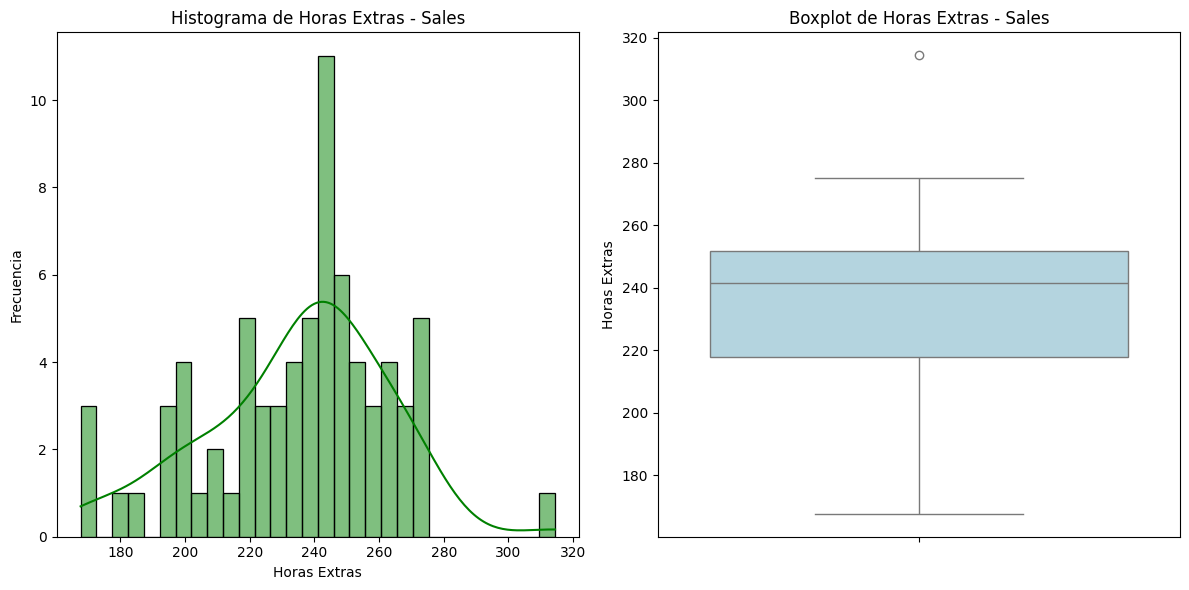

2025-05-24 22:18:13,129 - INFO - Gráficos de distribución renderizados para Sales


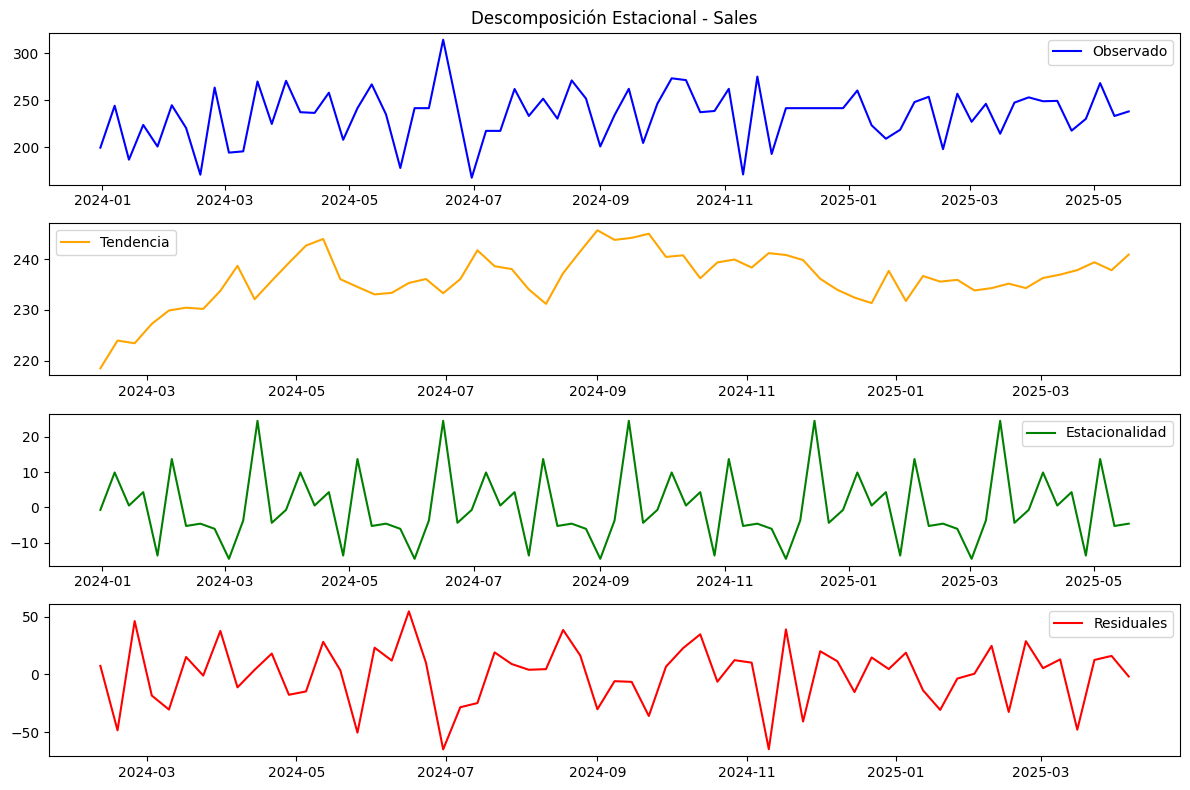

2025-05-24 22:18:17,354 - INFO - Gráfico de descomposición estacional renderizado para Sales
2025-05-24 22:18:17,358 - INFO - Problemas de índice para Sales: {'is_monotonic': True, 'has_duplicates': False, 'missing_dates': 0}
2025-05-24 22:18:17,370 - INFO - Resumen de estadísticas guardado en: EDA_Results\eda_summary_20250524_221718.csv


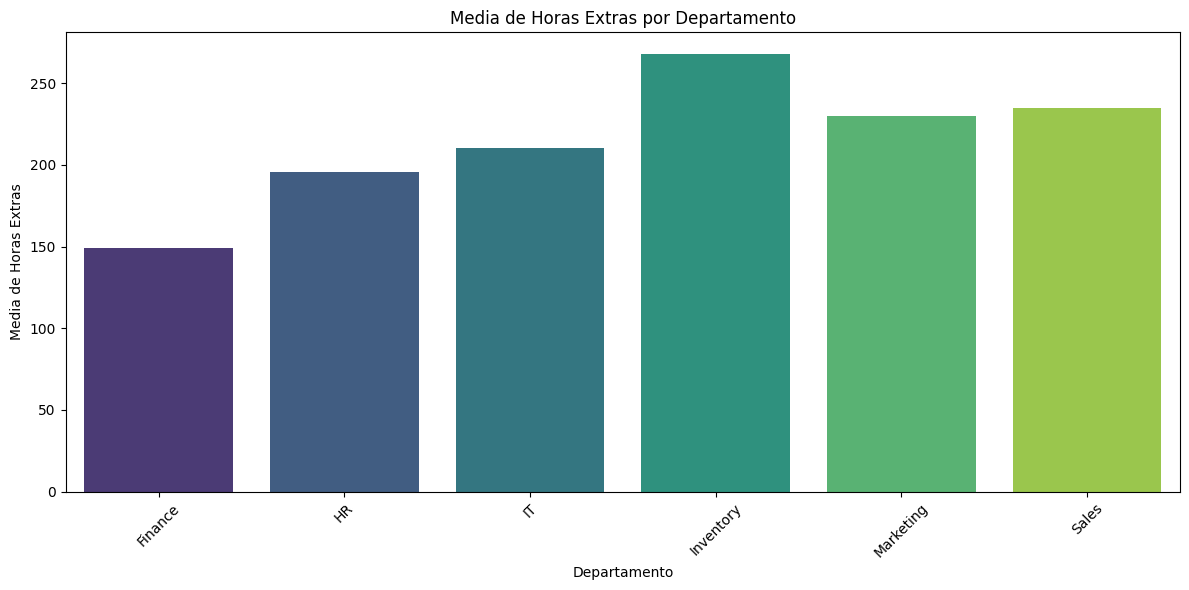

2025-05-24 22:18:19,071 - INFO - Gráfico comparativo renderizado


Resultados del EDA:

Finance:
{'count': 73.0, 'mean': 148.8616438356164, 'std': 23.179030514532034, 'min': 99.22, '25%': 132.48, '50%': 149.38, '75%': 161.9, 'max': 201.12, 'missing_count': 0.0, 'missing_percentage': 0.0, 'outlier_count_post_treatment': 0.0, 'index_issues': {'is_monotonic': True, 'has_duplicates': False, 'missing_dates': 0}}

HR:
{'count': 73.0, 'mean': 195.41082191780822, 'std': 22.865673918769875, 'min': 140.61, '25%': 183.02, '50%': 196.64, '75%': 210.73, 'max': 245.6, 'missing_count': 0.0, 'missing_percentage': 0.0, 'outlier_count_post_treatment': 1.0, 'index_issues': {'is_monotonic': True, 'has_duplicates': False, 'missing_dates': 0}}

Inventory:
{'count': 73.0, 'mean': 267.77890410958906, 'std': 24.90628108873809, 'min': 201.11, '25%': 256.55, '50%': 267.49, '75%': 282.49, 'max': 334.47, 'missing_count': 0.0, 'missing_percentage': 0.0, 'outlier_count_post_treatment': 4.0, 'index_issues': {'is_monotonic': True, 'has_duplicates': False, 'missing_dates': 0}}

IT:
{'

In [61]:

def detect_outliers(dept_data):
    """
    Detecta y trata outliers en la columna total_overtime usando el método IQR.

    Args:
        dept_data (pd.DataFrame): Datos del departamento con columna total_overtime.

    Returns:
        pd.DataFrame: Datos con outliers reemplazados por la mediana.
    """
    Q1 = dept_data['total_overtime'].quantile(0.25)
    Q3 = dept_data['total_overtime'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = dept_data[(dept_data['total_overtime'] < lower_bound) | (dept_data['total_overtime'] > upper_bound)]
    if not outliers.empty:
        logging.warning(f"Outliers detectados en {dept_data['department'].iloc[0]}:\n{outliers}")
        dept_data['total_overtime'] = np.where(
            (dept_data['total_overtime'] < lower_bound) | (dept_data['total_overtime'] > upper_bound),
            dept_data['total_overtime'].median(),
            dept_data['total_overtime']
        )
    return dept_data

def load_historical_data():
    """
    Carga datos históricos desde SQL Server y realiza preprocesamiento.

    Returns:
        pd.DataFrame: Datos históricos limpios y procesados.
    """
    conn = get_db_connection()
    query = "SELECT work_date, department, total_overtime FROM vw_historical_data ORDER BY work_date, department ASC"
    
    try:
        df = pd.read_sql(query, conn)
        logging.info(f"Datos cargados: {len(df)} registros")
        
        # Verificar datos nulos
        print("Valores nulos:\n", df.isnull().sum())
        df['total_overtime'] = df['total_overtime'].fillna(df['total_overtime'].median())
        
        # Convertir work_date a datetime
        df['work_date'] = pd.to_datetime(df['work_date']).dt.date
        df['work_date'] = pd.to_datetime(df['work_date'])
        
        # Verificar duplicados
        print("Duplicados:", df.duplicated(subset=['work_date', 'department']).sum())
        df = df.drop_duplicates(subset=['work_date', 'department'])
        
        # Tratar outliers por departamento
        for department in df['department'].unique():
            dept_data = df[df['department'] == department].copy()
            df.loc[dept_data.index, 'total_overtime'] = detect_outliers(dept_data)['total_overtime']
        
        print("Resumen de datos:")
        print("Departamentos únicos:", df['department'].unique())
        print("Fechas únicas:", sorted(df['work_date'].unique()))
        print("Total registros:", len(df))
        
        return df
    
    finally:
        conn.close()

def perform_eda(historical_data, output_dir='EDA_Results', seasonal_period=13):
    """
    Performs exploratory data analysis (EDA) for overtime data by department, rendering plots in the notebook.

    Args:
        historical_data (pd.DataFrame): DataFrame with columns 'department', 'work_date', 'total_overtime'.
        output_dir (str): Directory to save EDA summary CSV (plots are rendered, not saved).
        seasonal_period (int): Period for seasonal decomposition (e.g., 13 for weekly data, quarterly).

    Returns:
        dict: Summary statistics and missing data info for each department.
    """
    # Create output directory for CSV summary
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Initialize results dictionary
    eda_results = {}
    
    # Ensure work_date is the index and datetime
    if 'work_date' in historical_data.columns:
        historical_data['work_date'] = pd.to_datetime(historical_data['work_date'])
        historical_data = historical_data.set_index('work_date')
    
    # Get unique departments
    departments = historical_data['department'].unique()
    
    for department in departments:
        try:
            logging.info(f"Analizando departamento: {department}")
            dept_data = historical_data[historical_data['department'] == department]['total_overtime']
            
            # Skip if no data
            if dept_data.empty:
                logging.warning(f"No hay datos para {department}")
                continue
            
            # 1. Descriptive Statistics
            stats = dept_data.describe()
            missing_count = dept_data.isna().sum()
            missing_percentage = (missing_count / len(dept_data)) * 100
            stats['missing_count'] = missing_count
            stats['missing_percentage'] = missing_percentage
            
            # Detect outliers (post-treatment)
            Q1 = dept_data.quantile(0.25)
            Q3 = dept_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_count = ((dept_data < lower_bound) | (dept_data > upper_bound)).sum()
            stats['outlier_count_post_treatment'] = outlier_count
            
            eda_results[department] = stats.to_dict()
            
            # Log statistics
            logging.info(f"Estadísticas para {department}:\n{stats}")
            
            # 2. Time Series Plot
            plt.figure(figsize=(12, 6))
            plt.plot(dept_data.index, dept_data, label='Horas Extras', color='blue')
            plt.title(f'Serie Temporal de Horas Extras - {department}')
            plt.xlabel('Fecha')
            plt.ylabel('Horas Extras')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()  # Render in notebook
            logging.info(f"Gráfico de serie temporal renderizado para {department}")
            
            # 3. Distribution Plots
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            sns.histplot(dept_data.dropna(), bins=30, kde=True, color='green')
            plt.title(f'Histograma de Horas Extras - {department}')
            plt.xlabel('Horas Extras')
            plt.ylabel('Frecuencia')
            
            plt.subplot(1, 2, 2)
            sns.boxplot(y=dept_data.dropna(), color='lightblue')
            plt.title(f'Boxplot de Horas Extras - {department}')
            plt.ylabel('Horas Extras')
            plt.tight_layout()
            plt.show()  # Render in notebook
            logging.info(f"Gráficos de distribución renderizados para {department}")
            
            # 4. Seasonal Decomposition (if enough data)
            if len(dept_data.dropna()) >= 2 * seasonal_period:
                try:
                    # Ensure continuous weekly index for decomposition
                    dept_data = dept_data.asfreq('W', fill_value=dept_data.mean())
                    decomposition = seasonal_decompose(dept_data, model='additive', period=seasonal_period)
                    plt.figure(figsize=(12, 8))
                    
                    plt.subplot(4, 1, 1)
                    plt.plot(decomposition.observed, label='Observado', color='blue')
                    plt.title(f'Descomposición Estacional - {department}')
                    plt.legend()
                    
                    plt.subplot(4, 1, 2)
                    plt.plot(decomposition.trend, label='Tendencia', color='orange')
                    plt.legend()
                    
                    plt.subplot(4, 1, 3)
                    plt.plot(decomposition.seasonal, label='Estacionalidad', color='green')
                    plt.legend()
                    
                    plt.subplot(4, 1, 4)
                    plt.plot(decomposition.resid, label='Residuales', color='red')
                    plt.legend()
                    
                    plt.tight_layout()
                    plt.show()  # Render in notebook
                    logging.info(f"Gráfico de descomposición estacional renderizado para {department}")
                except Exception as e:
                    logging.warning(f"No se pudo realizar la descomposición estacional para {department}: {e}")
            else:
                logging.warning(f"No hay suficientes datos para la descomposición estacional en {department}")
            
            # 5. Check for index issues
            index_issues = {
                'is_monotonic': dept_data.index.is_monotonic_increasing,
                'has_duplicates': dept_data.index.has_duplicates,
                'missing_dates': (dept_data.index.to_series().diff() > pd.Timedelta(days=7)).sum()  # Weekly data
            }
            eda_results[department]['index_issues'] = index_issues
            logging.info(f"Problemas de índice para {department}: {index_issues}")
            
        except Exception as e:
            logging.error(f"Error en el EDA para {department}: {e}")
            eda_results[department] = {'error': str(e)}
    
    # Save summary statistics to CSV
    summary_df = pd.DataFrame.from_dict(eda_results, orient='index')
    summary_path = os.path.join(output_dir, f'eda_summary_{timestamp}.csv')
    summary_df.to_csv(summary_path)
    logging.info(f"Resumen de estadísticas guardado en: {summary_path}")
    
    # 6. Comparative Plot (Mean Overtime by Department)
    plt.figure(figsize=(12, 6))
    means = historical_data.groupby('department')['total_overtime'].mean()
    sns.barplot(x=means.index, y=means.values, hue=means.index, palette='viridis')
    plt.title('Media de Horas Extras por Departamento')
    plt.xlabel('Departamento')
    plt.ylabel('Media de Horas Extras')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()  # Render in notebook
    logging.info(f"Gráfico comparativo renderizado")
    
    return eda_results

# Example usage
if __name__ == "__main__":
    # Load data
    historical_data = load_historical_data()
    
    # Run EDA
    eda_results = perform_eda(historical_data, seasonal_period=13)  # Weekly data, quarterly period
    print("Resultados del EDA:")
    for dept, stats in eda_results.items():
        print(f"\n{dept}:\n{stats}")

## 4. Análisis Exploratorio: ACF, PACF, Estacionariedad y Estacionalidad

Realizamos un análisis exploratorio para verificar estacionariedad y detectar el período estacional automáticamente.

2025-05-24 22:29:22,079 - INFO - Iniciando análisis de estacionariedad y estacionalidad
2025-05-24 22:29:22,102 - INFO - Generando ACF/PACF para Finance con 20 lags


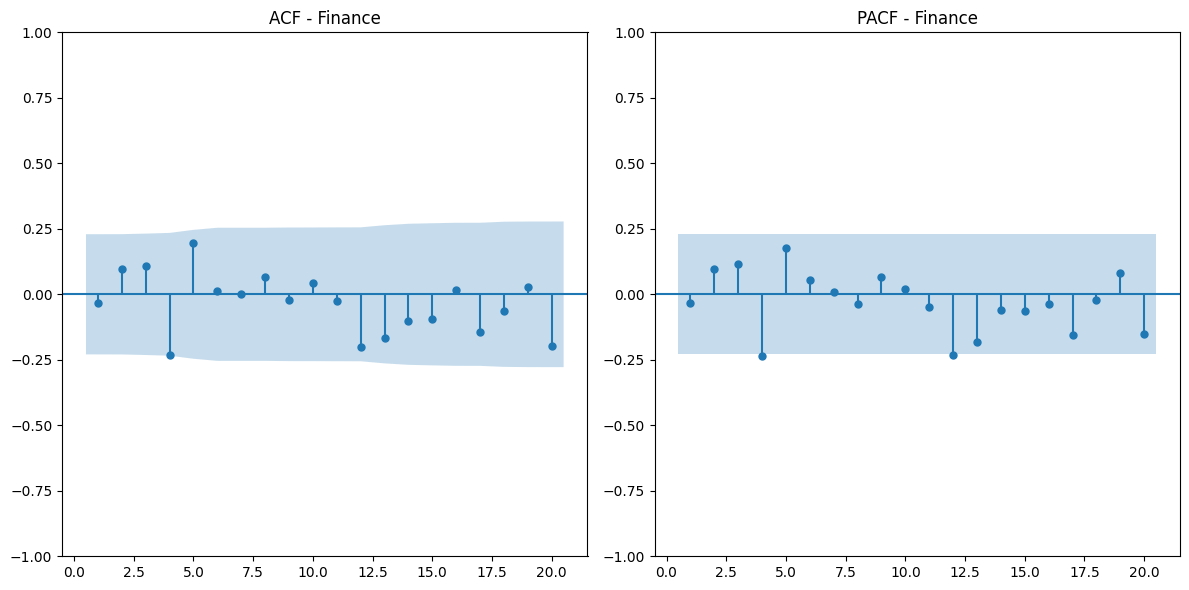

2025-05-24 22:29:27,369 - INFO - Gráficos ACF/PACF renderizados para Finance
2025-05-24 22:29:27,405 - INFO - Estacionariedad para Finance: p-value=0.000000, estacionario=True
2025-05-24 22:29:27,412 - INFO - No se detectó estacionalidad clara para total_overtime, usando m=1
2025-05-24 22:29:27,418 - INFO - Generando ACF/PACF para HR con 20 lags



Análisis de Estacionariedad para Finance
Número de observaciones: 73
Test Statistic: -8.712747
p-value: 0.000000
Valores Críticos:
  1%: -3.524624
  5%: -2.902607
  10%: -2.588679

Conclusión:
Datos estacionarios
Período estacional detectado para Finance: 1


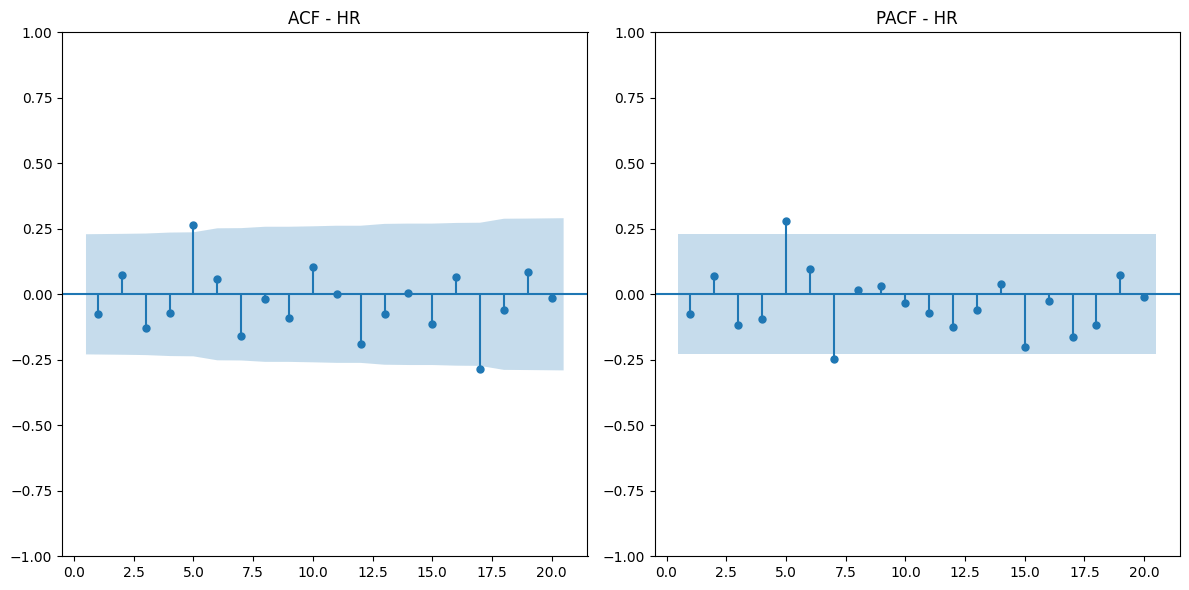

2025-05-24 22:29:31,691 - INFO - Gráficos ACF/PACF renderizados para HR
2025-05-24 22:29:32,578 - INFO - Estacionariedad para HR: p-value=0.042635, estacionario=True
2025-05-24 22:29:32,585 - INFO - Período estacional detectado para total_overtime: 17, picos significativos: [(5, 0.265556536703454), (17, 0.28543952986970467)]
2025-05-24 22:29:32,601 - INFO - Generando ACF/PACF para Inventory con 20 lags



Análisis de Estacionariedad para HR
Número de observaciones: 73
Test Statistic: -2.923936
p-value: 0.042635
Valores Críticos:
  1%: -3.533560
  5%: -2.906444
  10%: -2.590724

Conclusión:
Datos estacionarios
Período estacional detectado para HR: 17


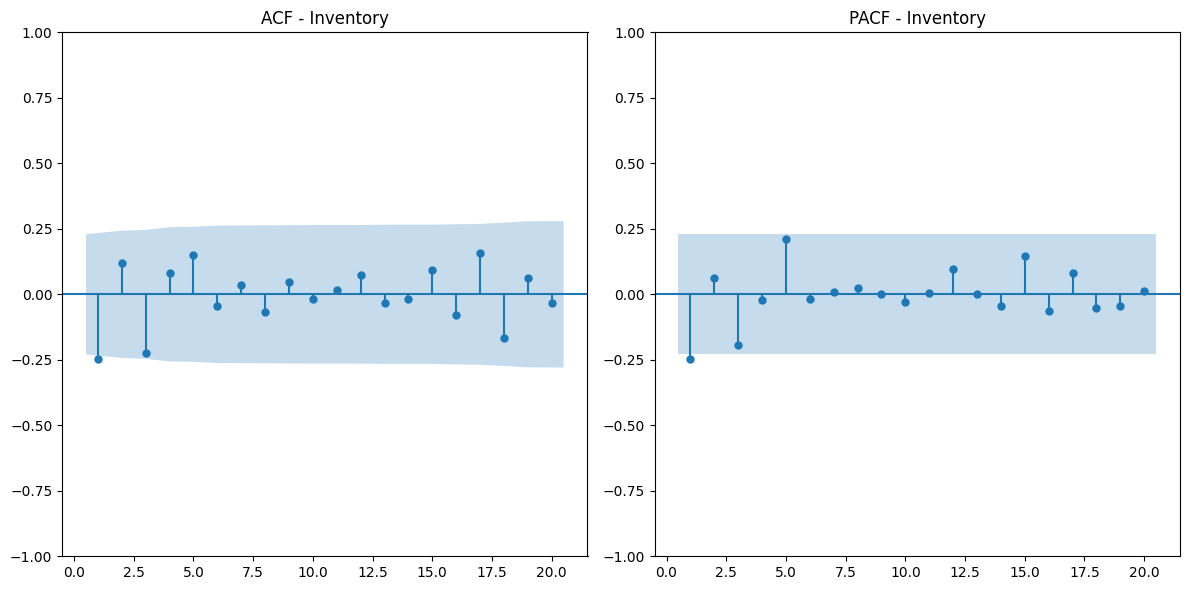

2025-05-24 22:29:36,346 - INFO - Gráficos ACF/PACF renderizados para Inventory
2025-05-24 22:29:36,366 - INFO - Estacionariedad para Inventory: p-value=0.000000, estacionario=True
2025-05-24 22:29:36,378 - INFO - Período estacional detectado para total_overtime: 1, picos significativos: [(1, 0.24599616329022858)]
2025-05-24 22:29:36,394 - INFO - Generando ACF/PACF para IT con 20 lags



Análisis de Estacionariedad para Inventory
Número de observaciones: 73
Test Statistic: -10.760920
p-value: 0.000000
Valores Críticos:
  1%: -3.524624
  5%: -2.902607
  10%: -2.588679

Conclusión:
Datos estacionarios
Período estacional detectado para Inventory: 1


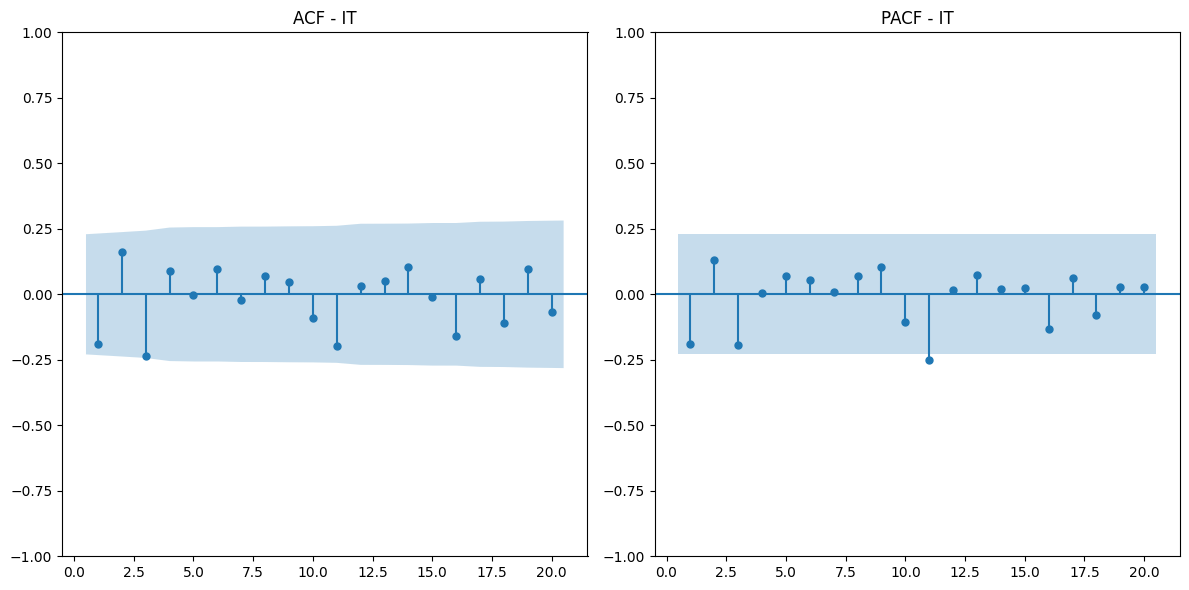

2025-05-24 22:29:40,455 - INFO - Gráficos ACF/PACF renderizados para IT
2025-05-24 22:29:40,536 - INFO - Estacionariedad para IT: p-value=0.000001, estacionario=True
2025-05-24 22:29:40,544 - INFO - No se detectó estacionalidad clara para total_overtime, usando m=1
2025-05-24 22:29:40,556 - INFO - Generando ACF/PACF para Marketing con 20 lags



Análisis de Estacionariedad para IT
Número de observaciones: 73
Test Statistic: -5.572436
p-value: 0.000001
Valores Críticos:
  1%: -3.527426
  5%: -2.903811
  10%: -2.589320

Conclusión:
Datos estacionarios
Período estacional detectado para IT: 1


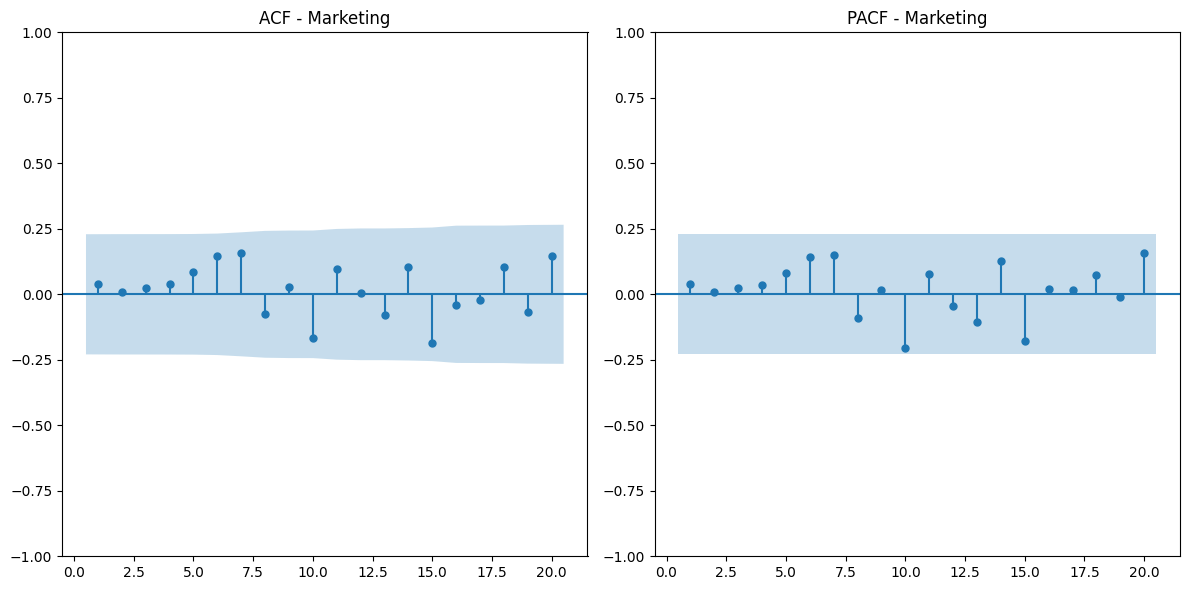

2025-05-24 22:29:45,149 - INFO - Gráficos ACF/PACF renderizados para Marketing
2025-05-24 22:29:45,214 - INFO - Estacionariedad para Marketing: p-value=0.000000, estacionario=True
2025-05-24 22:29:45,222 - INFO - No se detectó estacionalidad clara para total_overtime, usando m=1
2025-05-24 22:29:45,237 - INFO - Generando ACF/PACF para Sales con 20 lags



Análisis de Estacionariedad para Marketing
Número de observaciones: 73
Test Statistic: -8.096932
p-value: 0.000000
Valores Críticos:
  1%: -3.524624
  5%: -2.902607
  10%: -2.588679

Conclusión:
Datos estacionarios
Período estacional detectado para Marketing: 1


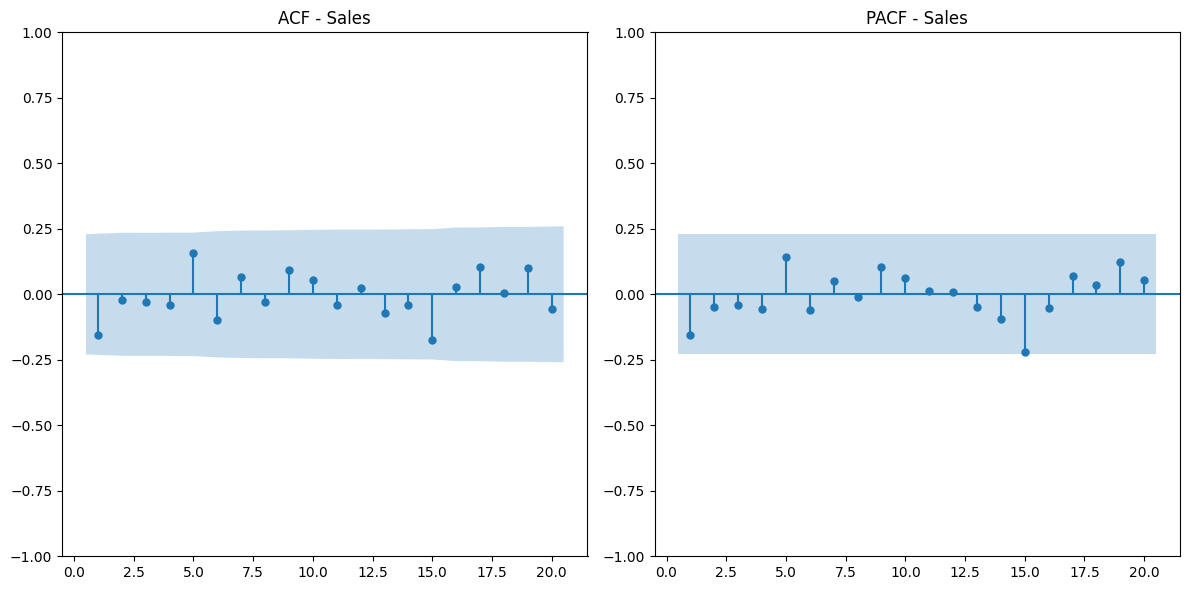

2025-05-24 22:29:48,344 - INFO - Gráficos ACF/PACF renderizados para Sales
2025-05-24 22:29:49,557 - INFO - Estacionariedad para Sales: p-value=0.000033, estacionario=True
2025-05-24 22:29:49,565 - INFO - No se detectó estacionalidad clara para total_overtime, usando m=1



Análisis de Estacionariedad para Sales
Número de observaciones: 73
Test Statistic: -4.914487
p-value: 0.000033
Valores Críticos:
  1%: -3.528890
  5%: -2.904440
  10%: -2.589656

Conclusión:
Datos estacionarios
Período estacional detectado para Sales: 1

Resumen de Estacionariedad por Departamento:


,department,test_statistic,p_value,is_stationary,n_observations
0,Finance,-8.712747,3.554658e-14,True,73
1,HR,-2.923936,4.263452e-02,True,73
2,Inventory,-10.760920,2.522166e-19,True,73
3,IT,-5.572436,1.457189e-06,True,73
4,Marketing,-8.096932,1.331310e-12,True,73
5,Sales,-4.914487,3.267927e-05,True,73



Resumen de Períodos Estacionales por Departamento:


,department,seasonal_period
0,Finance,1
1,HR,17
2,Inventory,1
3,IT,1
4,Marketing,1
5,Sales,1


2025-05-24 22:29:49,769 - INFO - Análisis de estacionariedad y estacionalidad completado


In [63]:
def plot_acf_pacf(data, department, lags=20):
    """
    Genera y muestra las gráficas ACF y PACF para un departamento.

    Args:
        data (pd.DataFrame): Datos del departamento con índice temporal y columna 'total_overtime'.
        department (str): Nombre del departamento.
        lags (int): Número de lags a mostrar (ajustado dinámicamente).

    Returns:
        None
    """
    try:
        series = data['total_overtime'].dropna()
        if series.empty:
            logging.warning(f"No hay datos válidos para {department}")
            return
        
        # Ajustar lags dinámicamente
        lags = min(lags, len(series)//2, 36)
        logging.info(f"Generando ACF/PACF para {department} con {lags} lags")
        
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        plot_acf(series, lags=lags, ax=plt.gca(), title=f'ACF - {department}', zero=False)
        
        plt.subplot(122)
        plot_pacf(series, lags=lags, ax=plt.gca(), title=f'PACF - {department}', zero=False)
        
        plt.tight_layout()
        plt.show()
        logging.info(f"Gráficos ACF/PACF renderizados para {department}")
        
    except Exception as e:
        logging.error(f"Error generando ACF/PACF para {department}: {e}")

def check_stationarity(dept_data, department):
    """
    Realiza la prueba de Dickey-Fuller para verificar estacionariedad.

    Args:
        dept_data (pd.DataFrame): Datos del departamento con índice temporal y columna 'total_overtime'.
        department (str): Nombre del departamento.

    Returns:
        dict: Resultados de la prueba.
    """
    try:
        series = dept_data['total_overtime'].dropna()
        if len(series) < 10:
            logging.warning(f"Datos insuficientes para {department}: {len(series)} observaciones")
            return {
                'department': department,
                'test_statistic': None,
                'p_value': None,
                'is_stationary': False,
                'n_observations': len(series)
            }
        
        result = adfuller(series)
        is_stationary = result[1] < 0.05
        
        print(f"\nAnálisis de Estacionariedad para {department}")
        print(f"Número de observaciones: {len(series)}")
        print(f"Test Statistic: {result[0]:.6f}")
        print(f"p-value: {result[1]:.6f}")
        print("Valores Críticos:")
        for key, value in result[4].items():
            print(f"  {key}: {value:.6f}")
        print("\nConclusión:")
        print("Datos estacionarios" if is_stationary else "Datos no estacionarios")
        
        logging.info(f"Estacionariedad para {department}: p-value={result[1]:.6f}, estacionario={is_stationary}")
        
        return {
            'department': department,
            'test_statistic': result[0],
            'p_value': result[1],
            'is_stationary': is_stationary,
            'n_observations': len(series)
        }
        
    except Exception as e:
        logging.error(f"Error en prueba de estacionariedad para {department}: {e}")
        return {
            'department': department,
            'test_statistic': None,
            'p_value': None,
            'is_stationary': False,
            'n_observations': len(series)
        }

def detect_seasonal_period(data, max_lags=52):
    """
    Detecta el período estacional analizando los picos significativos en la ACF.

    Args:
        data (pd.Series): Serie temporal.
        max_lags (int): Número máximo de lags a analizar (default: 52 para datos semanales).

    Returns:
        int: Período estacional detectado (o 1 si no hay estacionalidad).
    """
    try:
        series = data.dropna()
        if series.empty:
            logging.warning("Serie vacía, no se puede detectar estacionalidad")
            return 1
        
        if len(series) < 10:
            logging.warning(f"Datos insuficientes: {len(series)} observaciones")
            return 1
        
        # Ajustar max_lags
        max_lags = min(max_lags, len(series)//2, 52)
        acf_values, confint = acf(series, nlags=max_lags, alpha=0.05, fft=False)
        
        # Detectar picos significativos
        significant_lags = []
        for lag in range(1, max_lags + 1):
            upper_bound = confint[lag, 1] - acf_values[lag]
            lower_bound = confint[lag, 0] - acf_values[lag]
            if acf_values[lag] > upper_bound or acf_values[lag] < lower_bound:
                significant_lags.append((lag, abs(acf_values[lag])))
        
        # Priorizar períodos estacionales plausibles (13, 26, 52 para datos semanales)
        plausible_periods = [13, 26, 52]
        seasonal_period = 1
        if significant_lags:
            # Buscar el primer lag significativo en períodos plausibles
            for lag, _ in sorted(significant_lags):
                if lag in plausible_periods:
                    seasonal_period = lag
                    break
            else:
                # Si no hay períodos plausibles, tomar el lag con mayor ACF
                seasonal_period = max(significant_lags, key=lambda x: x[1])[0]
            
            logging.info(f"Período estacional detectado para {series.name or 'serie'}: {seasonal_period}, picos significativos: {significant_lags}")
        else:
            logging.info(f"No se detectó estacionalidad clara para {series.name or 'serie'}, usando m=1")
        
        return seasonal_period
        
    except Exception as e:
        logging.error(f"Error detectando período estacional: {e}")
        return 1

# Ejecutar análisis exploratorio
logging.info("Iniciando análisis de estacionariedad y estacionalidad")
stationarity_results = []
seasonal_periods = []

try:
    for department in historical_data['department'].unique():
        try:
            dept_data = historical_data[historical_data['department'] == department].set_index('work_date')
            if dept_data.empty:
                logging.warning(f"No hay datos para {department}")
                continue
            
            # Generar gráficos ACF/PACF
            plot_acf_pacf(dept_data, department)
            
            # Verificar estacionariedad
            stationarity_result = check_stationarity(dept_data, department)
            stationarity_results.append(stationarity_result)
            
            # Detectar período estacional
            seasonal_period = detect_seasonal_period(dept_data['total_overtime'])
            print(f"Período estacional detectado para {department}: {seasonal_period}")
            seasonal_periods.append({
                'department': department,
                'seasonal_period': seasonal_period
            })
            
        except Exception as e:
            logging.error(f"Error procesando {department}: {e}")
            
    # Resumen de estacionariedad
    stationarity_df = pd.DataFrame(stationarity_results)
    print("\nResumen de Estacionariedad por Departamento:")
    display(stationarity_df)
    
    # Resumen de períodos estacionales
    seasonal_df = pd.DataFrame(seasonal_periods)
    print("\nResumen de Períodos Estacionales por Departamento:")
    display(seasonal_df)
    
    logging.info("Análisis de estacionariedad y estacionalidad completado")
    
except Exception as e:
    logging.error(f"Error en el análisis exploratorio: {e}")

## 5. Entrenamiento y Validación del Modelo SARIMA

Entrenamos modelos SARIMA con períodos estacionales detectados automáticamente, validamos residuos, y realizamos validación cruzada.

Matriz de correlación entre departamentos:


department,Finance,HR,IT,Inventory,Marketing,Sales
department,,,,,,
Finance,1.000000,0.481614,0.241907,0.343211,0.472409,0.413953
HR,0.481614,1.000000,0.333997,0.300012,0.420417,0.397627
IT,0.241907,0.333997,1.000000,0.279263,0.400098,0.233751
Inventory,0.343211,0.300012,0.279263,1.000000,0.205865,0.384043
Marketing,0.472409,0.420417,0.400098,0.205865,1.000000,0.367633
Sales,0.413953,0.397627,0.233751,0.384043,0.367633,1.000000


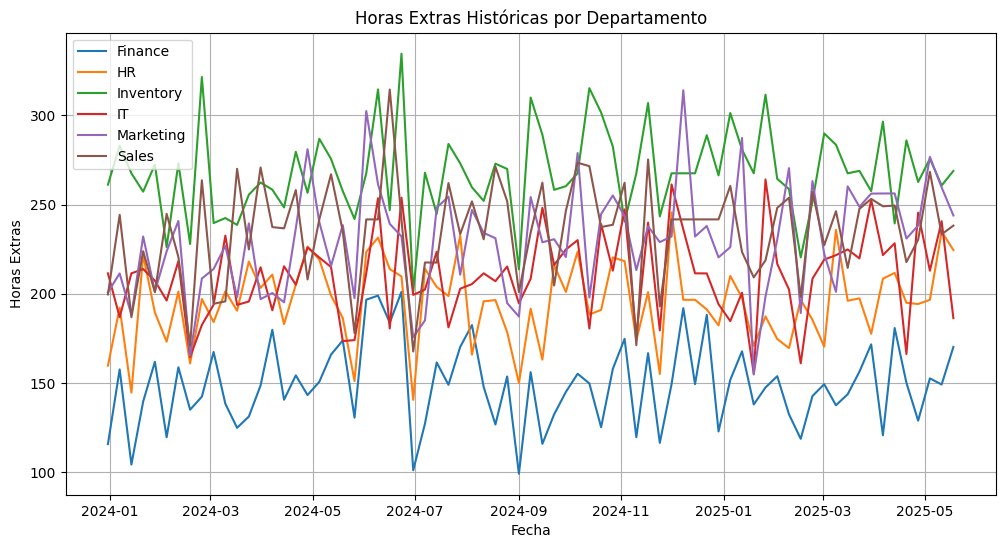

2025-05-24 22:31:27,661 - INFO - Período estacional seleccionado: 26 (std estacional: 17.8847)


Período estacional para Finance: 26


2025-05-24 22:32:10,324 - WARNING - Residuos no son ruido blanco para Finance (p-valor=0.0000)
2025-05-24 22:32:10,326 - INFO - Reintentando con parámetros más amplios para Finance


## 6. Generación de Predicciones

Generamos predicciones para las próximas 4 semanas con intervalos de confianza.

In [ ]:
def generate_predictions(model, model_type, last_date, periods=8):
    """
    Generates predictions for a given model (SARIMA or Holt).

    Args:
        model: Fitted SARIMA or Holt model.
        model_type (str): Type of model ('sarima' or 'holt').
        last_date (datetime): Last date in the historical data.
        periods (int): Number of periods to forecast (default: 8 weeks).

    Returns:
        pd.DataFrame: DataFrame with columns 'ds', 'yhat', 'yhat_lower', 'yhat_upper'.

    Raises:
        Exception: If prediction generation fails.
    """
    try:
        # Generate prediction dates starting immediately after the last date (weekly, Sundays)
        prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=periods, freq='W-SUN')
        if model_type == 'sarima':
            forecast = model.get_forecast(steps=periods)
            forecast_df = pd.DataFrame({
                'ds': prediction_dates,
                'yhat': forecast.predicted_mean.clip(lower=0),
                'yhat_lower': forecast.conf_int().iloc[:, 0].clip(lower=0),
                'yhat_upper': forecast.conf_int().iloc[:, 1].clip(lower=0)
            })
        else:  # Holt
            forecast = model.forecast(steps=periods).clip(lower=0)
            # Approximate confidence intervals using residual standard deviation
            residuals = model.resid
            std_err = np.std(residuals) if len(residuals) > 0 and not np.isnan(residuals).all() else 1.0
            forecast_df = pd.DataFrame({
                'ds': prediction_dates,
                'yhat': forecast,
                'yhat_lower': forecast - 1.96 * std_err,
                'yhat_upper': forecast + 1.96 * std_err
            })
            forecast_df[['yhat_lower', 'yhat_upper']] = forecast_df[['yhat_lower', 'yhat_upper']].clip(lower=0)
        
        forecast_df.set_index('ds', inplace=True)
        logging.info(f"Predicciones generadas para {model_type.upper()} model")
        return forecast_df
    except Exception as e:
        logging.error(f"Error generando predicciones para {model_type.upper()} model: {e}")
        raise

# Generate predictions for each department
department_forecasts = {}
for department in department_models.keys():
    try:
        dept_data = historical_data[historical_data['department'] == department]
        last_date = dept_data['work_date'].max()
        model_type = department_model_types.get(department, 'sarima')  # Default to sarima if not found
        forecast = generate_predictions(
            department_models[department],
            model_type,
            last_date
        )
        department_forecasts[department] = forecast
        print(f"Predicciones generadas para {department} ({model_type.upper()})")
    except Exception as e:
        print(f"No se pudieron generar predicciones para {department}: {e}")
        logging.error(f"No se pudieron generar predicciones para {department}: {e}")

## 7. Visualización de Predicciones

Creamos gráficos interactivos con Plotly para mostrar datos históricos, predicciones históricas, y pronósticos futuros.

In [ ]:
def plot_forecast(department, historical_data, forecast, model_type):
    """
    Creates an interactive Plotly visualization for the forecast.

    Args:
        department (str): Name of the department.
        historical_data (pd.DataFrame): Historical data with columns 'work_date', 'department', 'total_overtime'.
        forecast (pd.DataFrame): Forecast DataFrame with columns 'yhat', 'yhat_lower', 'yhat_upper' and datetime index.
        model_type (str): Type of model ('sarima' or 'holt').

    Returns:
        go.Figure: Plotly figure object.

    Raises:
        Exception: If visualization fails.
    """
    try:
        # Select last 24 weeks of historical data for the department
        hist_dept = historical_data[historical_data['department'] == department].tail(24).copy()
        fig = go.Figure()
        
        # Historical data
        fig.add_trace(
            go.Scatter(
                x=hist_dept['work_date'],
                y=hist_dept['total_overtime'],
                name='Datos Históricos',
                mode='markers+lines',
                line=dict(color='blue'),
                hovertemplate="<b>Fecha:</b> %{x}<br><b>Valor Real:</b> %{y:.1f}<extra></extra>"
            )
        )
        
        # Historical predictions
        model = department_models[department]
        if model_type == 'sarima':
            historical_predictions = model.get_prediction(start=hist_dept['work_date'].min())
            historical_mean = historical_predictions.predicted_mean.clip(lower=0)
        else:  # Holt
            historical_mean = model.fittedvalues.reindex(hist_dept['work_date']).clip(lower=0)
            # Fill any missing values with forward fill
            historical_mean = historical_mean.fillna(method='ffill')
        
        # Ajustar historical_mean para compensar el lag inherente del modelo (como en check_pattern_alignment)
        historical_mean_shifted = historical_mean.shift(-1).fillna(method='ffill')
        
        fig.add_trace(
            go.Scatter(
                x=hist_dept['work_date'],
                y=historical_mean_shifted,
                name='Predicción Histórica',
                mode='lines',
                line=dict(color='red', dash='dash'),
                hovertemplate="<b>Fecha:</b> %{x}<br><b>Predicción:</b> %{y:.1f}<extra></extra>"
            )
        )
        
        # Future forecast
        fig.add_trace(
            go.Scatter(
                x=[hist_dept['work_date'].iloc[-1]] + forecast.index.tolist(),
                y=[historical_mean_shifted.iloc[-1]] + forecast['yhat'].tolist(),
                name='Pronóstico',
                mode='lines',
                line=dict(color='red'),
                hovertemplate="<b>Fecha:</b> %{x}<br><b>Predicción:</b> %{y:.1f}<br>" +
                             "<b>IC Inferior:</b> %{customdata[0]:.1f}<br><b>IC Superior:</b> %{customdata[1]:.1f}<extra></extra>",
                customdata=np.column_stack((
                    [0] + forecast['yhat_lower'].tolist(),
                    [0] + forecast['yhat_upper'].tolist()
                ))
            )
        )
        
        # Confidence interval
        fig.add_trace(
            go.Scatter(
                x=forecast.index.tolist() + forecast.index.tolist()[::-1],
                y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'].tolist()[::-1],
                fill='toself',
                fillcolor='rgba(211,211,211,0.3)',
                line=dict(color='rgba(255,255,255,0)'),
                name='Intervalo de Confianza 95%',
                showlegend=True,
                hoverinfo='skip'
            )
        )
        
        fig.update_layout(
            title=f'Pronóstico de Horas Extra - {department} ({model_type.upper()})',
            xaxis_title='Fecha',
            yaxis_title='Horas Extra',
            hovermode='x unified',
            showlegend=True,
            template='plotly_white',
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=-0.4,
                xanchor="center",
                x=0.5
            )
        )
        
        return fig
    except Exception as e:
        logging.error(f"Error generando visualización para {department} ({model_type.upper()}): {e}")
        raise

# Generate and display visualizations
print("\nGenerando visualizaciones...")
for department in department_forecasts.keys():
    try:
        model_type = department_model_types.get(department, 'sarima')  # Default to sarima if not found
        fig = plot_forecast(
            department,
            historical_data,
            department_forecasts[department],
            model_type
        )
        fig.show()
        print(f"Visualización generada para {department} ({model_type.upper()})")
    except Exception as e:
        print(f"Error generando visualización para {department}: {e}")
        logging.error(f"Error generando visualización para {department}: {e}")
print("\nProceso de visualización completado.")

## 8. Guardar Modelo y Predicciones

Almacenamos los modelos en archivos .pkl y las predicciones con métricas en SQL Server.

In [ ]:

def calculate_metrics(dept_data, model, model_type, train_test_split=True, test_size=0.2):
    """
    Calculates evaluation metrics for the model.

    Args:
        dept_data (pd.DataFrame): Department data with temporal index.
        model: Fitted SARIMA or Holt model.
        model_type (str): Type of model ('sarima' or 'holt').
        train_test_split (bool): Whether to split data into train/test sets.
        test_size (float): Proportion of data to use as test set.

    Returns:
        dict: Metrics including rmse, mae, smape, mase, and model_quality.
    """
    try:
        # Ensure no NaN in input data
        if dept_data['total_overtime'].isna().any():
            logging.warning(f"Datos de {dept_data['department'].iloc[0]} contienen NaN. Rellenando con mediana.")
            dept_data['total_overtime'] = dept_data['total_overtime'].fillna(dept_data['total_overtime'].median())

        # Split data into train and test
        if train_test_split:
            train_size = int(len(dept_data) * (1 - test_size))
            train_data = dept_data.iloc[:train_size]
            test_data = dept_data.iloc[train_size:]
        else:
            train_data = dept_data
            test_data = dept_data

        # Get predictions
        if model_type == 'sarima':
            if train_test_split:
                predictions = model.get_forecast(steps=len(test_data)).predicted_mean
                predictions = predictions.reindex(test_data.index).clip(lower=0)
            else:
                predictions = model.get_prediction(start=dept_data.index[0], end=dept_data.index[-1]).predicted_mean
                predictions = predictions.reindex(dept_data.index).clip(lower=0)
            
            # Handle NaN in SARIMA predictions
            if predictions.isna().any():
                nan_count = predictions.isna().sum()
                logging.warning(f"Predicciones de {dept_data['department'].iloc[0]} ({model_type.upper()}) contienen {nan_count} NaN. Rellenando con mediana de datos reales.")
                predictions = predictions.fillna(dept_data['total_overtime'].median())
        else:  # Holt
            if train_test_split:
                predictions = model.forecast(steps=len(test_data))
                predictions = pd.Series(predictions, index=test_data.index).clip(lower=0)
            else:
                predictions = model.fittedvalues
                predictions = predictions.reindex(dept_data.index).clip(lower=0)
            
            # Handle NaN in HOLT predictions
            if predictions.isna().any():
                nan_count = predictions.isna().sum()
                logging.warning(f"Predicciones de {dept_data['department'].iloc[0]} ({model_type.upper()}) contienen {nan_count} NaN. Rellenando con mediana de datos reales.")
                predictions = predictions.fillna(dept_data['total_overtime'].median())

        actual = test_data['total_overtime'] if train_test_split else dept_data['total_overtime']

        # Ensure indices align
        common_index = actual.index.intersection(predictions.index)
        if len(common_index) == 0:
            logging.error(f"No hay índices comunes para {dept_data['department'].iloc[0]}. Índice real: {actual.index}, Índice predicciones: {predictions.index}")
            raise ValueError(f"No hay índices comunes para {dept_data['department'].iloc[0]}")
        actual = actual.loc[common_index]
        predictions = predictions.loc[common_index]

        # Log index alignment and prediction details
        logging.info(f"Índices alineados para {dept_data['department'].iloc[0]}: {len(common_index)} fechas comunes")
        logging.info(f"Predicciones para {dept_data['department'].iloc[0]}: min={predictions.min():.2f}, max={predictions.max():.2f}, mean={predictions.mean():.2f}")

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(actual, predictions))
        mae = mean_absolute_error(actual, predictions)
        smape = np.mean(2 * np.abs(predictions - actual) / (np.abs(predictions) + np.abs(actual) + 1e-10)) * 100
        naive_forecast = actual.shift(1).fillna(actual.mean())
        mase = mae / mean_absolute_error(actual[1:], naive_forecast[1:]) if naive_forecast.std() > 0 else float('inf')

        # Calculate department-specific thresholds based on mean overtime
        mean_overtime = dept_data['total_overtime'].mean()
        mae_threshold_good = 0.05 * mean_overtime  # 5% of mean
        mae_threshold_acceptable = 0.10 * mean_overtime  # 10% of mean
        rmse_threshold_good = 0.10 * mean_overtime  # 10% of mean
        rmse_threshold_acceptable = 0.20 * mean_overtime  # 20% of mean

        # Determine model quality
        if (mae < mae_threshold_good and smape < 10 and mase < 0.8 and rmse < rmse_threshold_good):
            quality = "Bueno"
        elif (mae < mae_threshold_acceptable and smape < 20 and mase < 1.2 and rmse < rmse_threshold_acceptable):
            quality = "Aceptable"
        else:
            quality = "Pobre"

        # Ensure finite values for SQL
        rmse = rmse if np.isfinite(rmse) else None
        mae = mae if np.isfinite(mae) else None
        smape = smape if np.isfinite(smape) else None
        mase = mase if np.isfinite(mase) else None

        return {
            'rmse': rmse,
            'mae': mae,
            'smape': smape,
            'mase': mase,
            'quality': quality
        }
    except Exception as e:
        logging.error(f"Error calculando métricas para {dept_data['department'].iloc[0]} ({model_type.upper()}): {e}")
        return {
            'rmse': None,
            'mae': None,
            'smape': None,
            'mase': None,
            'quality': 'Pobre'
        }

def save_predictions():
    """
    Saves models, predictions, and metrics to disk and SQL Server, and generates a summary.

    Returns:
        tuple: (predictions_summary_df, metrics_summary_df) for display.

    Raises:
        Exception: If saving fails.
    """
    os.makedirs('Modelos Entrenados', exist_ok=True)
    timestamp = datetime.datetime.now()
    metrics = {}
    predictions_summary = []
    metrics_summary = []
    
    # Save models and calculate metrics
    for department, model in department_models.items():
        try:
            model_type = department_model_types.get(department, 'sarima')
            model_path = f'Modelos Entrenados/overtime_forecast_model_{department}_{model_type}.pkl'
            joblib.dump(model, model_path)
            print(f"Modelo guardado para {department} ({model_type.upper()}) en: {model_path}")
            
            # Calculate metrics
            dept_data = historical_data[historical_data['department'] == department].set_index('work_date')
            metrics[department] = calculate_metrics(dept_data, model, model_type)
            
            # Collect metrics for summary
            metrics_summary.append({
                'Department': department,
                'Model Type': model_type.upper(),
                'RMSE': metrics[department]['rmse'],
                'MAE': metrics[department]['mae'],
                'SMAPE': metrics[department]['smape'],
                'MASE': metrics[department]['mase'],
                'Model Quality': metrics[department]['quality']
            })
        except Exception as e:
            print(f"Error guardando modelo o calculando métricas para {department}: {e}")
            logging.error(f"Error guardando modelo o calculando métricas para {department}: {e}")
    
    # Save predictions and metrics to database
    conn = get_db_connection()
    cursor = conn.cursor()
    
    try:
        # Create tables if they don’t exist
        cursor.execute("""
            IF NOT EXISTS (SELECT * FROM sys.tables WHERE name = 'Overtime_Predictions')
            CREATE TABLE Overtime_Predictions (
                id INT IDENTITY(1,1) PRIMARY KEY,
                timestamp DATETIME,
                department VARCHAR(100),
                prediction_date DATE,
                predicted_value FLOAT,
                confidence_lower FLOAT,
                confidence_upper FLOAT
            )
        """)
        
        cursor.execute("""
            IF NOT EXISTS (SELECT * FROM sys.tables WHERE name = 'ML_Model_Metrics_Overtime_Predictions')
            CREATE TABLE ML_Model_Metrics_Overtime_Predictions (
                id INT IDENTITY(1,1) PRIMARY KEY,
                timestamp DATETIME,
                department VARCHAR(100),
                rmse FLOAT,
                mae FLOAT,
                smape FLOAT,
                mase FLOAT,
                model_quality VARCHAR(50)
            )
        """)
        
        # Insert predictions and metrics
        for department, forecast in department_forecasts.items():
            try:
                for _, row in forecast.iterrows():
                    predicted_value = row['yhat'] if pd.notna(row['yhat']) else None
                    confidence_lower = row['yhat_lower'] if pd.notna(row['yhat_lower']) else None
                    confidence_upper = row['yhat_upper'] if pd.notna(row['yhat_upper']) else None
                    
                    cursor.execute("""
                        INSERT INTO Overtime_Predictions 
                        (timestamp, department, prediction_date, predicted_value, confidence_lower, confidence_upper)
                        VALUES (%s, %s, %s, %s, %s, %s)
                    """, (
                        timestamp,
                        department,
                        row.name,
                        predicted_value,
                        confidence_lower,
                        confidence_upper
                    ))
                    
                    # Collect predictions for summary
                    predictions_summary.append({
                        'Department': department,
                        'Prediction Date': row.name,
                        'Predicted Value': predicted_value,
                        'Confidence Lower': confidence_lower,
                        'Confidence Upper': confidence_upper
                    })
                
                metric = metrics.get(department, {
                    'rmse': None,
                    'mae': None,
                    'smape': None,
                    'mase': None,
                    'quality': 'Pobre'
                })
                
                cursor.execute("""
                    INSERT INTO ML_Model_Metrics_Overtime_Predictions 
                    (timestamp, department, rmse, mae, smape, mase, model_quality)
                    VALUES (%s, %s, %s, %s, %s, %s, %s)
                """, (
                    timestamp,
                    department,
                    metric['rmse'],
                    metric['mae'],
                    metric['smape'],
                    metric['mase'],
                    metric['quality']
                ))
            except Exception as e:
                print(f"Error insertando datos para {department}: {e}")
                logging.error(f"Error insertando datos para {department}: {e}")
        
        conn.commit()
        logging.info("Predicciones y métricas guardadas exitosamente")
        
        # Create summary DataFrames
        predictions_summary_df = pd.DataFrame(predictions_summary)
        metrics_summary_df = pd.DataFrame(metrics_summary)
        
        # Display summary
        print("\n=== Resumen de Modelos y Predicciones ===")
        print("\nModelos y Métricas por Departamento:")
        display(metrics_summary_df)
        
        print("\nValores Predichos con Intervalos de Confianza:")
        display(predictions_summary_df)
        
        return predictions_summary_df, metrics_summary_df
    
    except Exception as e:
        conn.rollback()
        print(f"Error al guardar los datos: {e}")
        logging.error(f"Error al guardar los datos: {e}")
        raise
    finally:
        conn.close()

def verify_tables():
    """
    Verifies the number of records in the database tables.
    """
    conn = get_db_connection()
    cursor = conn.cursor()
    try:
        cursor.execute("SELECT COUNT(*) FROM Overtime_Predictions")
        pred_count = cursor.fetchone()[0]
        
        cursor.execute("SELECT COUNT(*) FROM ML_Model_Metrics_Overtime_Predictions")
        metrics_count = cursor.fetchone()[0]
        
        print(f"\nRegistros en Overtime_Predictions: {pred_count}")
        print(f"Registros en ML_Model_Metrics: {metrics_count}")
    except Exception as e:
        print(f"Error verificando tablas: {e}")
        logging.error(f"Error verificando tablas: {e}")
    finally:
        conn.close()

# Execute saving and display summary
try:
    predictions_summary_df, metrics_summary_df = save_predictions()
    print("\nDatos guardados exitosamente en la base de datos.")
except Exception as e:
    print(f"\nError al guardar los datos: {str(e)}")

# Verify tables
verify_tables()